# Compare VCFs between STR genotype callers

## Code to parse the VCF file

In [2]:
def circular_permuted(x):
    return([x[i:] + x[:i] for i in range(len(x))])

In [3]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

def self_and_rev_complement(in_dna):
    all_possible = [in_dna]
    
    # Get reverse complement
    dna = Seq(in_dna, generic_dna)
    rev_complement = str(dna.reverse_complement())
    all_possible.append(rev_complement)
    return(all_possible)

In [4]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

def normalise_str(in_dna):
    """Find all possible eqivalent STR sequences. 
    And return the first alphabetically.
    
    For example, TA = AT. But would return AT.
    """
    all_possible = []
    # Circularly permute original sequence and reverse complement
    for seq in self_and_rev_complement(in_dna):
        for permuted_seq in circular_permuted(seq): # Switch to faster permutation (6)
            all_possible.append(permuted_seq)

    # Sort and take the first
    all_possible.sort()
    return(all_possible[0])

In [5]:
# parse VCF files of STR genotype calls (from LobSTR and RepeatSeq)
# Compare the results (compare the loci, not genotypes)

import vcf
import csv

def parse_vcf(fname, dirname, outname):
    fieldnames=['chr', 'pos', 'refallelelen', 'repeatunit', 'normrepeatunit', 'repeatunitlen', 'genotype', 'depth']
    with open(dirname + fname, 'r') as f:
        with open(outname, 'w') as csvfile:
            csvwriter = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                   delimiter=',', extrasaction='ignore')
            csvwriter.writeheader()
    
            vcf_reader = vcf.Reader(f)
            sample1 = vcf_reader.samples[0] # Get list of samples in the VCF. save the first

            for record in vcf_reader:
    
                info = {}
        
                # Data to extract:
                # Allele Length Offset(s)" - need to figure out what this is!
        
                # Locus data
                info['chr'] = record.CHROM
                info['pos'] = record.POS
                info['refallelelen'] = record.INFO['RL']
                info['repeatunit'] = record.INFO['RU']
                # Calculated
                info['normrepeatunit'] = normalise_str(info['repeatunit'])
                info['repeatunitlen'] = len(info['repeatunit']) 
                
                # Genotype data
                info['genotype'] = record.genotype(sample1)['GT']

                # Not sure if this is for the individual sample, or over all samples.
                try:
                    info['depth'] = record.INFO['DP']
                except KeyError:
                    try:
                        info['depth'] = record.genotype(sample1)['DP']
                    except KeyError:
                        info['depth'] = None

                csvwriter.writerow(info)        

In [6]:
#dirname = '/Users/hd_vlsci/Documents/git/STR-pipelines/data/intersections_LobSTR-RepeatSeq/'
#lobstr = 'intersection0_10.vcf' # Called by LobSTR only
#both = 'intersection0_10_1.vcf' # Called by LobSTR and RepeatSeq
#repeatseq = 'intersection0_11.vcf' # Called by RepeatSeq only

#parse_vcf(both, dirname, outname='LobSTR_RepeatSEQ_intersect.csv')
#parse_vcf(lobstr, dirname, outname='LobSTR_only.csv')
#parse_vcf(repeatseq, dirname, outname='RepeatSEQ_only.csv')

In [7]:
# Extract more specific genotypes. Not sure if these are on the same scale?

# LobSTR: 
##FORMAT=<ID=GB,Number=1,Type=String,Description="Genotype given in bp difference from reference">
# Seems to match up to the genotype (GT) order. Ref and alt may not be in any particular order, but they match up with GB?

# RepeatSeq: 
##INFO=<ID=AL,Number=A,Type=Integer,Description="Allele Length Offset(s)">


# Extract Scores:

# Both: 
# QUAL

# QUAL: The Phred scaled probability that a REF/ALT polymorphism exists at this site given sequencing data. 
# Because the Phred scale is -10 * log(1-p), a value of 10 indicates a 1 in 10 chance of error, 
# while a 100 indicates a 1 in 10^10 chance. These values can grow very large when a large amount of NGS data 
# is used for variant calling.

# QUAL - quality: Phred-scaled quality score for the assertion made in ALT. i.e. −10log10 prob(call in ALT is
# wrong). If ALT is ‘.’ (no variant) then this is −10log10 prob(variant), and if ALT is not ‘.’ this is −10log10
# prob(no variant). High QUAL scores indicate high confidence calls. Although traditionally people use integer
# phred scores, this field is permitted to be a floating point to enable higher resolution for low confidence calls if
# desired. If unknown, the missing value should be specified. (Numeric)

# LobSTR:
##FORMAT=<ID=PL,Number=G,Type=Integer,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
##FORMAT=<ID=Q,Number=1,Type=Float,Description="Likelihood ratio score of allelotype call">

# RepeatSeq: 
##FORMAT=<ID=GL,Number=G,Type=Float,Description="Genotype likelihood">

# GL : genotype likelihoods comprised of comma separated floating point log10-scaled likelihoods for all possible
# genotypes given the set of alleles defined in the REF and ALT fields. In presence of the GT field the same
# ploidy is expected and the canonical order is used; without GT field, diploidy is assumed. If A is the allele in
# REF and B,C,... are the alleles as ordered in ALT, the ordering of genotypes for the likelihoods is given by:
# F(j/k) = (k*(k+1)/2)+j. In other words, for biallelic sites the ordering is: AA,AB,BB; for triallelic sites the
# ordering is: AA,AB,BB,AC,BC,CC, etc. For example: GT:GL 0/1:-323.03,-99.29,-802.53 (Floats)
# 5
# • PL : the phred-scaled genotype likelihoods rounded to the closest integer (and otherwise defined precisely as
# the GL field) (Integers)


In [8]:
def full_genotype(GT, REF, ALT, sort=True):
    """
    Convert an index based genotype to a DNA sequence genotype [optionally sort the alleles alphabetically]
    e.g. '0/1' -> 'AGTTTT/A' [ -> 'A/AGTTTT' ]
    
    
    GT: Genotype string as in VCF4.1 e.g. '0/1' = heterozgyous ref/alt
    REF: Reference allele string e.g. 'AGTTTT' 
    ALT: List of alternate allele strings e.g. ['A', 'AGTTTTGTTTT'] corresponding to the indexes in GT
    """
    indices = [int(x) for x in GT.split('/')]
    ref_list = [REF.upper()]
    alt_list = [str(x).upper() for x in ALT] # Convert alleles to strings because vcf gives them as objects
    alleles = ref_list + alt_list
    if sort:
        genotype_list = sorted([alleles[indices[0]], alleles[indices[1]]])
    else:
        genotype_list = [alleles[indices[0]], alleles[indices[1]]]
        
    return('{0}/{1}'.format(genotype_list[0], genotype_list[1]))

In [9]:
full_genotype('0/1', 'AGTTTT', ['A', 'AGTTTTGTTTT'], sort=False)

'AGTTTT/A'

In [10]:
def indel_genotype(GT, REF, ALT, sort=True, return_list=False):
    """
    Convert an index based genotype to indel size genotype [optionally sort the alleles numerically]
    e.g. '0/1' -> 'AGTTTT/A' -> '0/-5' [ -> '-5/0' ]
    
    
    GT: Genotype string as in VCF4.1 e.g. '0/1' = heterozgyous ref/alt
    REF: Reference allele string e.g. AGTTTT 
    ALT: List of alternate allele strings e.g. [A, AGTTTTGTTTT] corresponding to the indexes in GT
    """
    
    ref_len = len(REF)
    genotype_lens = [len(x)-ref_len for x in full_genotype(GT, REF, ALT, sort=False).split('/')]
    
    if sort:
        genotype_lens = sorted(genotype_lens)
        
    if return_list:
        return(genotype_lens)
        
    return('{0}/{1}'.format(genotype_lens[0], genotype_lens[1]))

In [11]:
indel_genotype('0/1', 'AGTTTT', ['A', 'AGTTTTGTTTT'], sort=True)

'-5/0'

In [12]:

def str_genotype(indel_GT, ref_len, repeat_unit_len, sort=True, return_list=False):
    """
    Convert an indel size genotype to a genotype in terms of number of repeat units 
    [optionally sort the alleles numerically]
    e.g. REF: 'ATAT', ALT: 'ATATAT', GT: '0/1'
    indel_GT = '0/2'
    ref_len = 4
    repeat_unit_len = 2
    return: '2.0/3.0'
    
    indel_GT: Genotype string in bp difference from reference e.g. '-5/0'
    ref_len: Length in bp of the reference allele (int)
    repeat_unit_len: Length in bp of the repeat unit/motif (int)
    """
    str_lens = [(float(x) + ref_len)/repeat_unit_len for x in indel_GT.split('/')]
    
    if sort:
        str_lens = sorted(str_lens)
    
    if return_list:
        return(str_lens)
        
    return('{0}/{1}'.format(str_lens[0], str_lens[1]))

In [13]:
def genotype_distance(GT1, GT2):
    """Calculate the 'distance' between two STR loci.
    The distance is the sum of the minimum absolute differences.
    e.g. 
    GT1 = '2/3'
    GT2 = '2/4'
    distance = min(
        (abs(2-2) + abs(3-4)), (abs(2-4) + abs(3-2))
        )
    = 1
    
    GT1, GT2: Genotype in terms of the number of repeat units (string containing ints/floats)
    
    """
    GT1_list = [float(x) for x in GT1.split('/')]
    GT2_list = [float(x) for x in GT2.split('/')]
    
    distance = min(
        (abs(GT1_list[0]-GT2_list[0]) + abs(GT1_list[1]-GT2_list[1])), 
        (abs(GT1_list[0]-GT2_list[1]) + abs(GT1_list[1]-GT2_list[0]))
        )
    return(distance)

In [14]:
def genotype_category(GT):
    """Categorise the genotype into one of 4 possibile groups:
    homozygous_alt_alt = c('1/1', '2/2', '3/3', '4/4')
    heterozygous_ref_alt = c('0/1', '0/2', '0/3', '0/4', '1/0', '2/0', '3/0', '4/0')
    heterozygous_alt_alt = c('1/2', '1/3', '1/4', '2/3', '2/4', '3/4')
    homozygous_ref_ref = c('0/0')
    
    GT: genotype string containing two integers e.g. '0/0'
    returns one of four possible genotype strings: '0/0', '0/1', '1/1', '1/2'
    """
    
    GT_list = [int(x) for x in GT.split('/')]
    if GT_list[0] == 0 and GT_list[1] == 0:
        return('0/0')
    if GT_list[0] == 0 or GT_list[1] == 0:
        return('0/1')    
    if GT_list[0] == GT_list[1]:
        return('1/1')
    else:
        return('1/2')

In [15]:
# parse VCF files of STR genotype calls (from LobSTR and RepeatSeq)
# Compare the genotypes call be each

import vcf
from vcf.utils import walk_together
import csv

def compare_genotypes(filename1, filename2, outfile):
    """
    Assumes:
    filename1 is a LobSTR VCF
    filename2 is a RepeatSeq VCF
    Only one sample per VCF
    Both VCFs are genotypes of the same sample
    """
    
    # Headers for the output CSV
    fieldnames=[
        'chr', 'pos', 
        'software',
        'LobSTR-REF', 'RepeatSeq-REF',
        'LobSTR-ALT', 'RepeatSeq-ALT',
        'LobSTR-QUAL', 'RepeatSeq-QUAL',
        'LobSTR-refallelelen', 'RepeatSeq-refallelelen',
        'LobSTR-repeatunit', 'RepeatSeq-repeatunit',
        'LobSTR-normrepeatunit', 'RepeatSeq-normrepeatunit',
        'LobSTR-repeatunitlen', 'RepeatSeq-repeatunitlen',
        'LobSTR-genotype', 'RepeatSeq-genotype', 
        'LobSTR-depth', 'RepeatSeq-depth',        
        'LobSTR-PL', 'LobSTR-Q', 'RepeatSeq-GL',
        'LobSTR-fullgenotype', 'RepeatSeq-fullgenotype',
        'LobSTR-indelgenotype', 'RepeatSeq-indelgenotype',
        'LobSTR-strgenotype', 'RepeatSeq-strgenotype',
        'LobSTR-genotypecategory', 'RepeatSeq-genotypecategory',
        'LobSTR-allele1', 'LobSTR-allele2',
        'RepeatSeq-allele1', 'RepeatSeq-allele2',
        'LobSTR-indel1', 'LobSTR-indel2',
        'RepeatSeq-indel1', 'RepeatSeq-indel2',
        'identical-genotype', 'same-indel-size', 'genotype-distance'
                ]
    #XXX need to update these ^
    
    # Open vcf files for reading and open output CSV file for writing
    with open(filename1) as f1, open(filename2) as f2, open(outfile, 'w') as csvfile:
        csvwriter = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                   delimiter=',', extrasaction='ignore')
        csvwriter.writeheader()

        # Read in VCFs as vcf.Reader objects
        vcf1 = vcf.Reader(f1)
        vcf2 = vcf.Reader(f2)
        
        for locus in walk_together(vcf1, vcf2):
            info = {}
            
            record1 = locus[0]
            record2 = locus[1]
            
            # Locus data
            if locus[0] != None: # LobSTR
                info['chr'] = record1.CHROM
                info['pos'] = record1.POS
            elif locus[1] != None: # RepeatSeq
                info['chr'] = record2.CHROM
                info['pos'] = record2.POS 
                
            # LobSTR
            if locus[0] != None:
                info['software'] = 'LobSTR'
                info['LobSTR'] = 1
                info['LobSTR-QUAL'] = record1.QUAL
                info['LobSTR-REF'] = record1.REF
                info['LobSTR-ALT'] = record1.ALT
                info['LobSTR-refallelelen'] = int(record1.INFO['RL'])
                info['LobSTR-repeatunit'] = record1.INFO['RU']
                info['LobSTR-normrepeatunit'] = normalise_str(info['LobSTR-repeatunit'])
                info['LobSTR-repeatunitlen'] = len(info['LobSTR-repeatunit']) 
                for sample in record1.samples:
                    info['LobSTR-genotype'] = sample['GT'] # Genotype
                    info['LobSTR-PL'] = sample['PL'] # Normalized, Phred-scaled likelihoods for genotypes
                    info['LobSTR-Q'] = sample['Q'] # Likelihood ratio score of allelotype call
                    info['LobSTR-depth'] = sample['DP']
                info['LobSTR-fullgenotype'] = full_genotype(info['LobSTR-genotype'], 
                                                info['LobSTR-REF'], info['LobSTR-ALT'])
                info['LobSTR-indelgenotype'] = indel_genotype(info['LobSTR-genotype'], 
                                                info['LobSTR-REF'], info['LobSTR-ALT'])
                info['LobSTR-strgenotype'] = str_genotype(info['LobSTR-indelgenotype'], 
                                                          info['LobSTR-refallelelen'], 
                                                          info['LobSTR-repeatunitlen'])
                info['LobSTR-allele1'], info['LobSTR-allele2'] = str_genotype(info['LobSTR-indelgenotype'], 
                                                                              info['LobSTR-refallelelen'], 
                                                                              info['LobSTR-repeatunitlen'], 
                                                                              return_list=True)
                info['LobSTR-indel1'], info['LobSTR-indel2'] = indel_genotype(info['LobSTR-genotype'], 
                                                                              info['LobSTR-REF'], 
                                                                              info['LobSTR-ALT'],
                                                                              return_list=True)
                info['LobSTR-genotypecategory'] = genotype_category(info['LobSTR-genotype'])
            else:
                info['LobSTR'] = 0

            # RepeatSeq
            if locus[1] != None:
                info['software'] = 'RepeatSeq'
                info['RepeatSeq-QUAL'] = record2.QUAL
                info['RepeatSeq-REF'] = record2.REF
                info['RepeatSeq-ALT'] = record2.ALT
                info['RepeatSeq-refallelelen'] = int(record2.INFO['RL'])
                info['RepeatSeq-repeatunit'] = record2.INFO['RU']
                info['RepeatSeq-normrepeatunit'] = normalise_str(info['RepeatSeq-repeatunit'])
                info['RepeatSeq-repeatunitlen'] = len(info['RepeatSeq-repeatunit']) 
                info['RepeatSeq-depth'] = record2.INFO['DP']
                for sample in record2.samples:
                    info['RepeatSeq-genotype'] = sample['GT']
                    info['RepeatSeq-GL'] = sample['GL'] # Genotype likelihood"
                info['RepeatSeq-fullgenotype'] = full_genotype(info['RepeatSeq-genotype'], 
                                                info['RepeatSeq-REF'], info['RepeatSeq-ALT'])
                info['RepeatSeq-indelgenotype'] = indel_genotype(info['RepeatSeq-genotype'], 
                                                info['RepeatSeq-REF'], info['RepeatSeq-ALT'])
                info['RepeatSeq-strgenotype'] = str_genotype(info['RepeatSeq-indelgenotype'], 
                                                             info['RepeatSeq-refallelelen'], 
                                                             info['RepeatSeq-repeatunitlen'])
                info['RepeatSeq-allele1'], info['RepeatSeq-allele2'] = str_genotype(info['RepeatSeq-indelgenotype'], 
                                                                                    info['RepeatSeq-refallelelen'], 
                                                                                    info['RepeatSeq-repeatunitlen'], 
                                                                                    return_list=True)
                info['RepeatSeq-indel1'], info['RepeatSeq-indel2'] = indel_genotype(info['RepeatSeq-genotype'], 
                                                                              info['RepeatSeq-REF'], 
                                                                              info['RepeatSeq-ALT'],
                                                                              return_list=True)
                info['RepeatSeq-genotypecategory'] = genotype_category(info['RepeatSeq-genotype'])
            else:
                info['RepeatSeq'] = 0
                
            # Both LobSTR and RepeatSeq produced genotype
            if locus[0] != None and locus[1] != None:
                info['software'] = 'LobSTR_RepeatSeq'
                info['identical-genotype'] = False
                if info['LobSTR-fullgenotype'] == info['RepeatSeq-fullgenotype']:
                    info['identical-genotype'] = True
                info['same-indel-size'] = False
                if info['LobSTR-indelgenotype'] == info['RepeatSeq-indelgenotype']:
                    info['same-indel-size'] = True
                info['genotype-distance'] = genotype_distance(info['LobSTR-strgenotype'], info['RepeatSeq-strgenotype'])
            csvwriter.writerow(info)
            

In [16]:
dirname = '/Users/hd_vlsci/Documents/git/STR-pipelines/data/'
lobstr = 'NA20845_LobSTR.renamed.target.trimmed.vcf' # All normalised LobSTR calls
repeatseq = 'NA20845_RepeatSeq.renamed.target.trimmed.vcf' # All normalised RepeatSeq calls

#compare_genotypes(dirname+lobstr, dirname+repeatseq, 'LobSTR_RepeatSEQ_genotypes.csv')


In [17]:
%load_ext rpy2.ipython

In [18]:
%%R
# Load libraries
library("VennDiagram")
library("ggplot2")
library("reshape2")

Loading required package: grid
Use suppressPackageStartupMessages to eliminate package startup messages.


## LobSTR vs. RepeatSeq - using default aligner (LobSTR and BWA MEM for RepeatSeq)

In [19]:
%%R
# Load data
genotype.csv = read.csv("LobSTR_RepeatSEQ_genotypes.csv")
all.data = genotype.csv

genotype.distance.group
    0     1     2    3+ 
17977  9620  2330  1935 


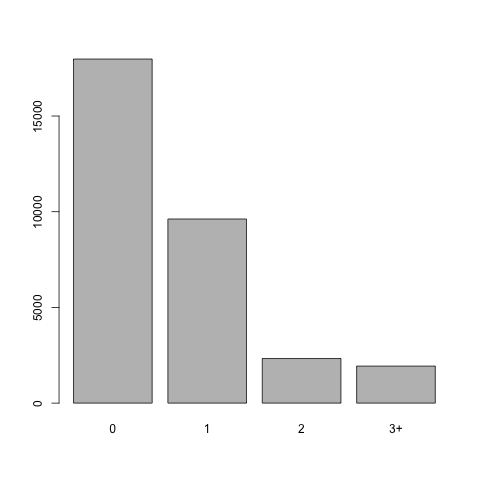

In [20]:
%%R
LobSTR.RepeatSeq = all.data[all.data$software == 'LobSTR_RepeatSeq',] # Filter to loci shared by both
LobSTR.RepeatSeq = LobSTR.RepeatSeq[!LobSTR.RepeatSeq$LobSTR.genotype == '0/0',] # Remove loci where LobSTR called 0/0 genotype

# Categorise Genotype Distance
genotype.distance.group = cut(LobSTR.RepeatSeq$genotype.distance, c(-Inf, seq(0, 2, 1), Inf), labels=c(0:2,'3+') )
LobSTR.RepeatSeq = cbind(LobSTR.RepeatSeq, genotype.distance.group)

print(table(genotype.distance.group))
barplot(table(genotype.distance.group))

In [21]:
%%R
names(all.data)

 [1] "chr"                        "pos"                       
 [3] "software"                   "LobSTR.REF"                
 [5] "RepeatSeq.REF"              "LobSTR.ALT"                
 [7] "RepeatSeq.ALT"              "LobSTR.QUAL"               
 [9] "RepeatSeq.QUAL"             "LobSTR.refallelelen"       
[11] "RepeatSeq.refallelelen"     "LobSTR.repeatunit"         
[13] "RepeatSeq.repeatunit"       "LobSTR.normrepeatunit"     
[15] "RepeatSeq.normrepeatunit"   "LobSTR.repeatunitlen"      
[17] "RepeatSeq.repeatunitlen"    "LobSTR.genotype"           
[19] "RepeatSeq.genotype"         "LobSTR.depth"              
[21] "RepeatSeq.depth"            "LobSTR.PL"                 
[23] "LobSTR.Q"                   "RepeatSeq.GL"              
[25] "LobSTR.fullgenotype"        "RepeatSeq.fullgenotype"    
[27] "LobSTR.indelgenotype"       "RepeatSeq.indelgenotype"   
[29] "LobSTR.strgenotype"         "RepeatSeq.strgenotype"     
[31] "LobSTR.genotypecategory"    "RepeatSeq.genotypeca

In [22]:
%%R
# Function to plot a pairwise Venn diagram
plot.venn = function(intersection, LobSTR_only, RepeatSeq_only, label.position=c(0,0)) {
    LobSTR = LobSTR_only + intersection
    RepeatSeq = RepeatSeq_only + intersection

    grid.newpage()
    draw.pairwise.venn(LobSTR, RepeatSeq, intersection, category = c("LobSTR", "RepeatSeq"),
        lty = rep("blank", 2), fill = c("light blue", "pink"),
        alpha = rep(0.5, 2), cat.dist = rep(0.025, 2), cat.pos=label.position)
}

(polygon[GRID.polygon.1], polygon[GRID.polygon.2], polygon[GRID.polygon.3], polygon[GRID.polygon.4], text[GRID.text.5], text[GRID.text.6], text[GRID.text.7], lines[GRID.lines.8], text[GRID.text.9], text[GRID.text.10]) 


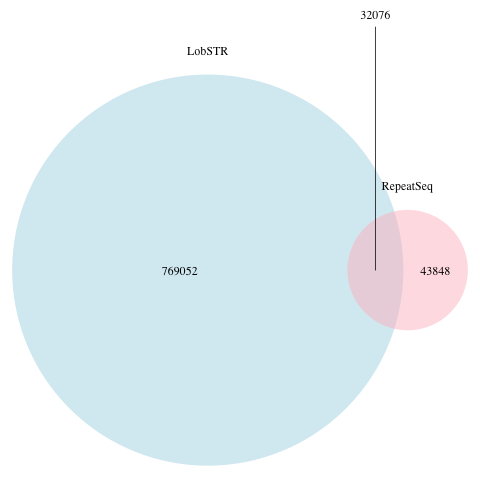

In [23]:
%%R

# Venn with all data
venn.table = table(all.data$software)
intersection = venn.table['LobSTR_RepeatSeq']
LobSTR_only = venn.table['LobSTR']
RepeatSeq_only = venn.table['RepeatSeq']
plot.venn(intersection, LobSTR_only, RepeatSeq_only)

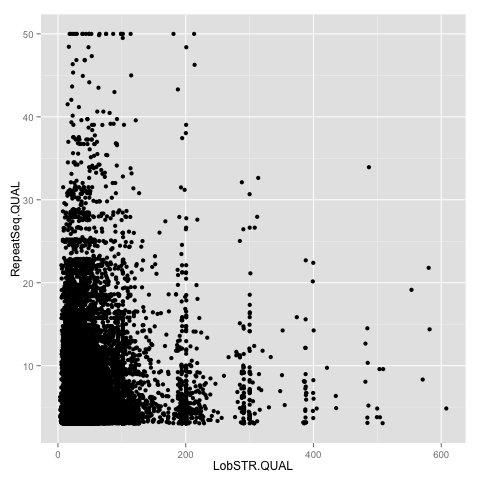

In [24]:
%%R

p = ggplot(LobSTR.RepeatSeq, aes(x = LobSTR.QUAL, y = RepeatSeq.QUAL)) +
    geom_point()
print(p)

In [25]:
%%R
QUAL.cor = cor.test(LobSTR.RepeatSeq$LobSTR.QUAL, LobSTR.RepeatSeq$RepeatSeq.QUAL)
print(QUAL.cor)


	Pearson's product-moment correlation

data:  LobSTR.RepeatSeq$LobSTR.QUAL and LobSTR.RepeatSeq$RepeatSeq.QUAL
t = 19.656, df = 31860, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09859733 0.12029486
sample estimates:
      cor 
0.1094591 



In [26]:
%%R

# Calculate slope and intercept of line of best fit
QUAL.lm = coef(lm(RepeatSeq.QUAL ~ LobSTR.QUAL, data = LobSTR.RepeatSeq)) # y ~ x
print(QUAL.lm)
intercept = QUAL.lm[1]
slope = QUAL.lm[2]

(Intercept) LobSTR.QUAL 
 6.19444474  0.01320646 


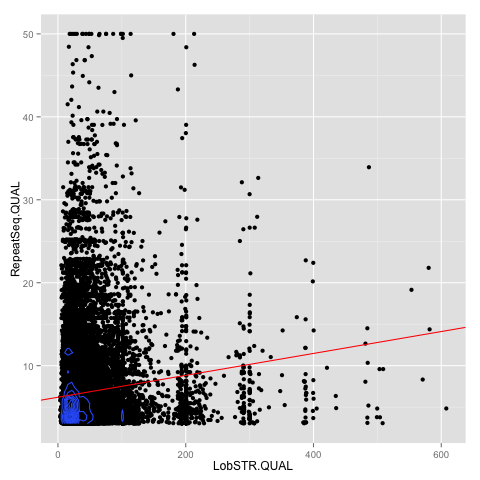

In [27]:
%%R
p = ggplot(LobSTR.RepeatSeq, aes(x = LobSTR.QUAL, y = RepeatSeq.QUAL)) +
    geom_point() +
    geom_density2d() + 
    geom_abline(intercept = intercept, slope = slope, colour = 'red') #+ coord_cartesian(xlim = c(0,50),ylim = c(0,50))
print(p)

[1] "Counts"

      False  True 
    0 14559 17303 
[1] "Percentage"

            False     True 
 0.00000 45.69393 54.30607 


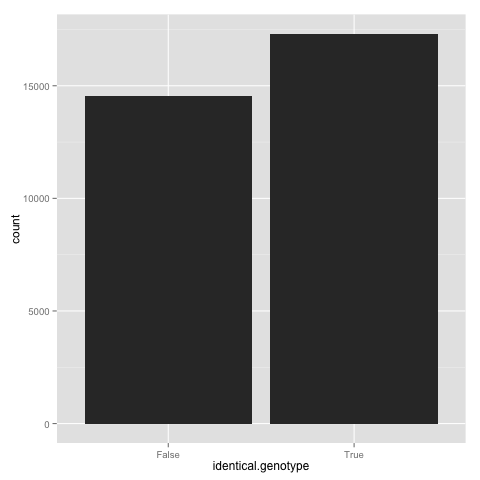

In [28]:
%%R

p = ggplot(LobSTR.RepeatSeq, aes(x = identical.genotype)) +
    geom_histogram() 
print(p)

print('Counts')
print(table(LobSTR.RepeatSeq$identical.genotype))
print('Percentage')
print(table(LobSTR.RepeatSeq$identical.genotype)/sum(table(LobSTR.RepeatSeq$identical.genotype))*100)

[1] "Counts"

      False  True 
    0 13883 17979 
[1] "Percentage"

            False     True 
 0.00000 43.57228 56.42772 


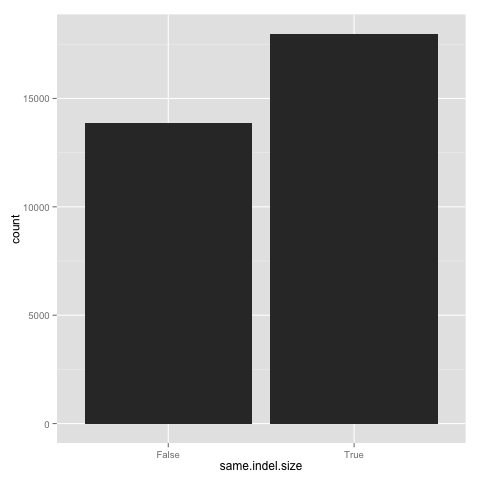

In [29]:
%%R

p = ggplot(LobSTR.RepeatSeq, aes(x = same.indel.size)) +
    geom_histogram() 
print(p)

print('Counts')
print(table(LobSTR.RepeatSeq$same.indel.size))
print('Percentage')
print(table(LobSTR.RepeatSeq$same.indel.size)/sum(table(LobSTR.RepeatSeq$same.indel.size))*100)

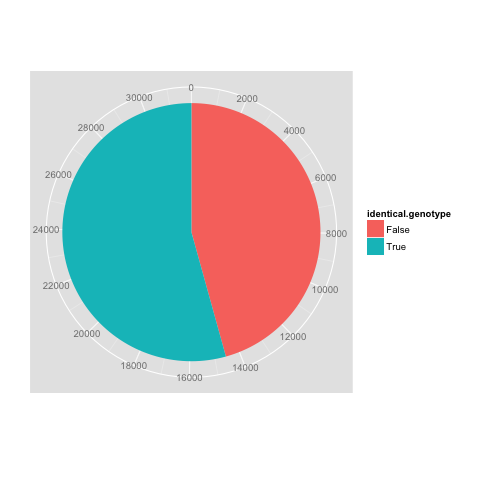

In [30]:
%%R

# A pie chart = stacked bar chart + polar coordinates
p = ggplot(LobSTR.RepeatSeq, aes(x = factor(1), fill = identical.genotype)) +
 geom_bar(width = 1) + coord_polar(theta = "y") +#+ annotate("text", x = 0, y = 0, label = "Some text")
    xlab("") + ylab("") + scale_y_continuous(breaks=seq(0, 30000, 2000)) + scale_x_discrete(breaks=NULL)
print(p)

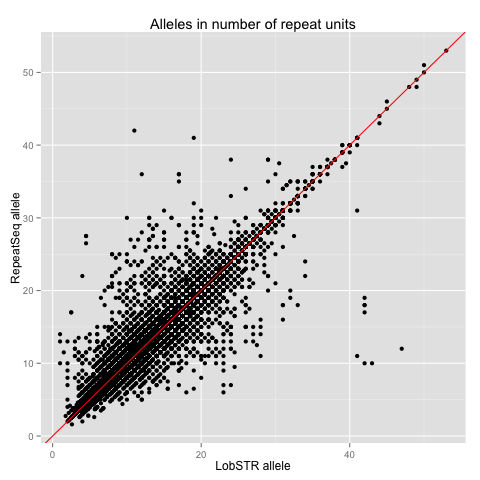

In [31]:
%%R
# Two dots for each genotype at each locus: small allele against small, large against large.
p = ggplot(LobSTR.RepeatSeq) +
    geom_point(aes(x = LobSTR.allele1, y = RepeatSeq.allele1)) +
    geom_point(aes(x = LobSTR.allele2, y = RepeatSeq.allele2)) +
    geom_abline(intercept = 0, slope = 1, colour = 'red') +
    labs(title="Alleles in number of repeat units", 
         x='LobSTR allele', y='RepeatSeq allele')
print(p)

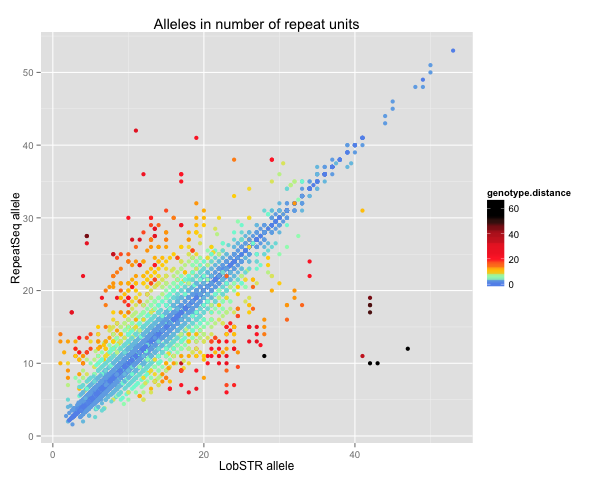

In [32]:
%%R -w 600
# Two dots for each genotype at each locus: small allele against small, large against large.
p = ggplot(LobSTR.RepeatSeq, aes(colour=genotype.distance)) +
    geom_point(aes(x = LobSTR.allele1, y = RepeatSeq.allele1)) +
    geom_point(aes(x = LobSTR.allele2, y = RepeatSeq.allele2)) +
    scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
                                     'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
                                     'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
                                     'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units", 
         x='LobSTR allele', y='RepeatSeq allele')
print(p)


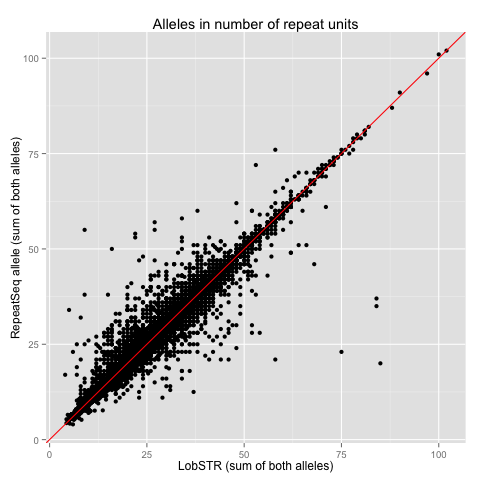

In [33]:
%%R
p = ggplot(LobSTR.RepeatSeq) +
    geom_point(aes(x = LobSTR.allele1+LobSTR.allele2, y = RepeatSeq.allele1+RepeatSeq.allele2)) +
    geom_abline(intercept = 0, slope = 1, colour = 'red') +
    labs(title="Alleles in number of repeat units", 
         x='LobSTR (sum of both alleles)', y='RepeatSeq allele (sum of both alleles)')
print(p)

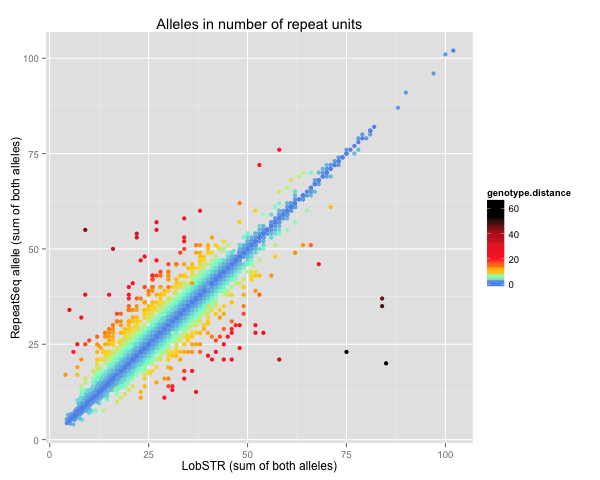

In [34]:
%%R -w 600
p = ggplot(LobSTR.RepeatSeq, aes(colour=genotype.distance)) +
    geom_point(aes(x = LobSTR.allele1+LobSTR.allele2, y = RepeatSeq.allele1+RepeatSeq.allele2)) +
    scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
                                     'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
                                     'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
                                     'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units", 
         x='LobSTR (sum of both alleles)', y='RepeatSeq allele (sum of both alleles)')
print(p)



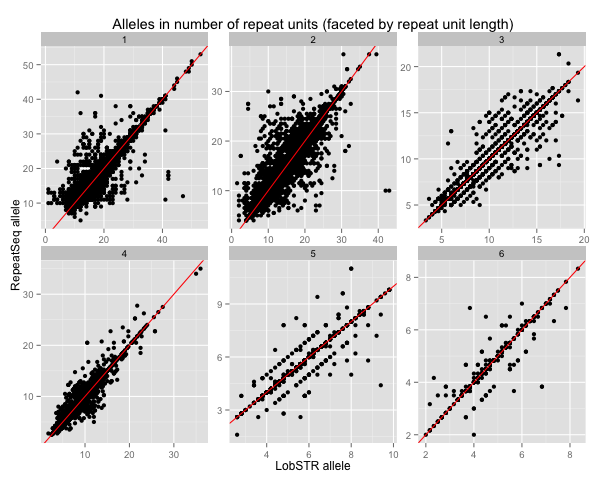

In [35]:
%%R -w 600
# Two dots for each genotype at each locus: small allele against small, large against large.
p = ggplot(LobSTR.RepeatSeq) +
    geom_point(aes(x = LobSTR.allele1, y = RepeatSeq.allele1)) +
    geom_point(aes(x = LobSTR.allele2, y = RepeatSeq.allele2)) +
    geom_abline(intercept = 0, slope = 1, colour = 'red') +
    facet_wrap( ~ RepeatSeq.repeatunitlen, scales="free") +
    labs(title="Alleles in number of repeat units (faceted by repeat unit length)", 
         x='LobSTR allele', y='RepeatSeq allele')
print(p)

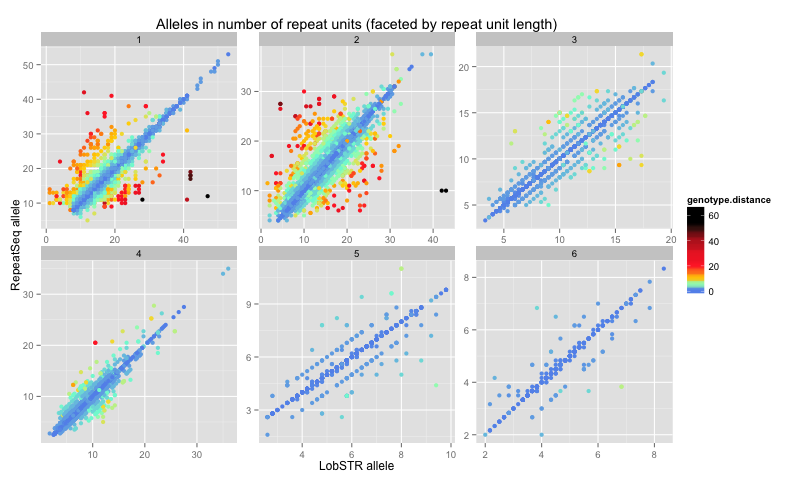

In [36]:
%%R -w 800
# Two dots for each genotype at each locus: small allele against small, large against large.
p = ggplot(LobSTR.RepeatSeq, aes(colour=genotype.distance)) +
    geom_point(aes(x = LobSTR.allele1, y = RepeatSeq.allele1)) +
    geom_point(aes(x = LobSTR.allele2, y = RepeatSeq.allele2)) +
    facet_wrap( ~ RepeatSeq.repeatunitlen, scales="free") +
    scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
                                     'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
                                     'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
                                     'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units (faceted by repeat unit length)", 
         x='LobSTR allele', y='RepeatSeq allele')
print(p)

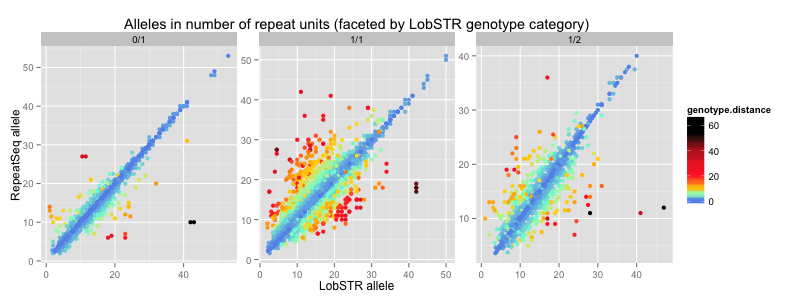

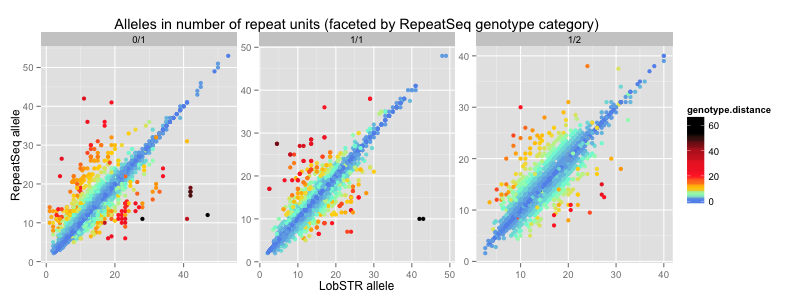

In [37]:
%%R -w 800 -h 300
# Two dots for each genotype at each locus: small allele against small, large against large.
p = ggplot(LobSTR.RepeatSeq, aes(colour=genotype.distance)) +
    geom_point(aes(x = LobSTR.allele1, y = RepeatSeq.allele1)) +
    geom_point(aes(x = LobSTR.allele2, y = RepeatSeq.allele2)) +
    facet_wrap( ~ LobSTR.genotypecategory, scales="free") +
    scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
                                     'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
                                     'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
                                     'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units (faceted by LobSTR genotype category)", 
         x='LobSTR allele', y='RepeatSeq allele')
print(p)

# Two dots for each genotype at each locus: small allele against small, large against large.
p = ggplot(LobSTR.RepeatSeq, aes(colour=genotype.distance)) +
    geom_point(aes(x = LobSTR.allele1, y = RepeatSeq.allele1)) +
    geom_point(aes(x = LobSTR.allele2, y = RepeatSeq.allele2)) +
    facet_wrap( ~ RepeatSeq.genotypecategory, scales="free") +
    scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
                                     'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
                                     'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
                                     'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units (faceted by RepeatSeq genotype category)", 
         x='LobSTR allele', y='RepeatSeq allele')
print(p)

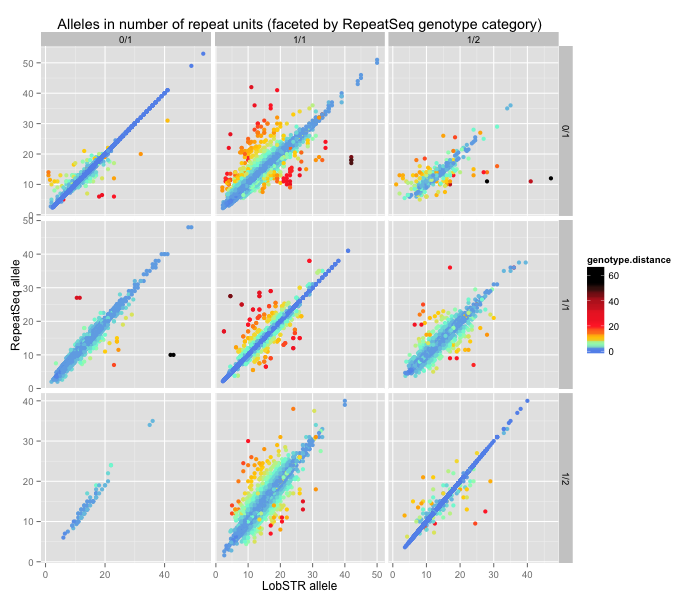

In [38]:
%%R -w 700 -h 600
# Two dots for each genotype at each locus: small allele against small, large against large.
p = ggplot(LobSTR.RepeatSeq, aes(colour=genotype.distance)) +
    geom_point(aes(x = LobSTR.allele1, y = RepeatSeq.allele1)) +
    geom_point(aes(x = LobSTR.allele2, y = RepeatSeq.allele2)) +
    facet_grid(RepeatSeq.genotypecategory ~ LobSTR.genotypecategory, scales="free") +
    scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
                                     'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
                                     'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
                                     'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units (faceted by RepeatSeq genotype category)", 
         x='LobSTR allele', y='RepeatSeq allele')
print(p)

In [39]:
%%R
temp.data.all = all.data[c('LobSTR.depth', 'RepeatSeq.depth', 'software')]
temp.data = temp.data.all[temp.data.all$software == 'LobSTR_RepeatSeq',]
temp.data$software = 'RepeatSeq_LobSTR'
temp.data = rbind(temp.data.all, temp.data)


In [40]:
%%R
temp.data[temp.data$software == 'LobSTR_RepeatSeq',]$RepeatSeq.depth = NA
temp.data[temp.data$software == 'RepeatSeq_LobSTR',]$LobSTR.depth = NA

In [41]:
%%R
library(plyr)
temp.data$software = revalue(temp.data$software, 
                             c("LobSTR"="LobSTR only", "LobSTR_RepeatSeq"="intersection LobSTR depth",
            "RepeatSeq_LobSTR"="intersection RepeatSeq depth", "RepeatSeq"="RepeatSeq only"))

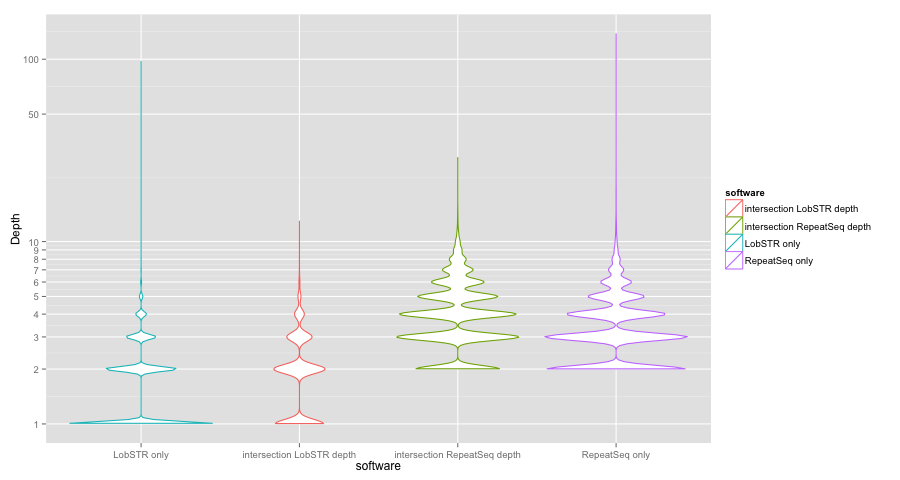

In [42]:
%%R -w 900

# Violin plots of depth
p = ggplot(temp.data) +
    geom_violin(aes(x = software, y=LobSTR.depth, color=software)) +
    geom_violin(aes(x = software, y=RepeatSeq.depth, color=software)) + 
    scale_y_log10(breaks= c(seq(1, 10, 1), 50, 100) ) +
    ylab('Depth') +
    scale_x_discrete(limits=c("LobSTR only", "intersection LobSTR depth",
            "intersection RepeatSeq depth", "RepeatSeq only"))
print(p)

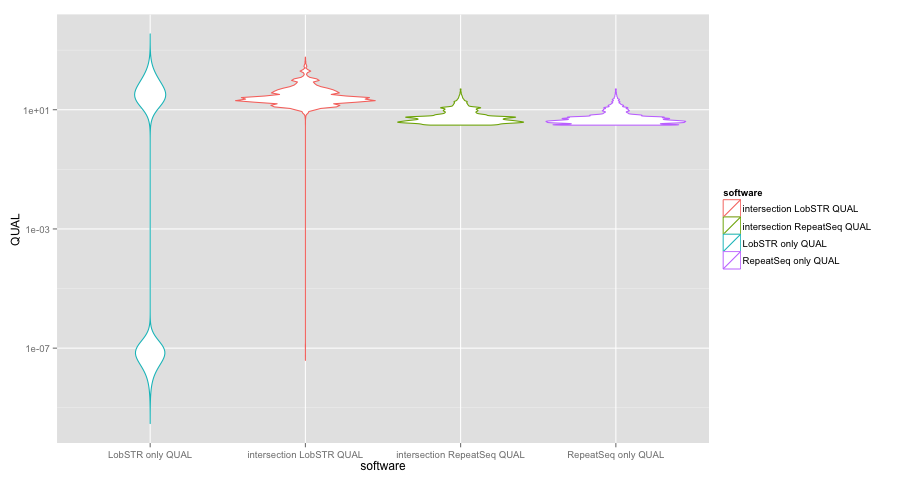

In [43]:
%%R -w 900

temp.data.all = all.data[c('LobSTR.QUAL', 'RepeatSeq.QUAL', 'software')]
temp.data = temp.data.all[temp.data.all$software == 'LobSTR_RepeatSeq',]
temp.data$software = 'RepeatSeq_LobSTR'
temp.data = rbind(temp.data.all, temp.data)

temp.data[temp.data$software == 'LobSTR_RepeatSeq',]$RepeatSeq.QUAL = NA
temp.data[temp.data$software == 'RepeatSeq_LobSTR',]$LobSTR.QUAL = NA

#library(plyr)
temp.data$software = revalue(temp.data$software, 
                             c("LobSTR"="LobSTR only QUAL", "LobSTR_RepeatSeq"="intersection LobSTR QUAL",
            "RepeatSeq_LobSTR"="intersection RepeatSeq QUAL", "RepeatSeq"="RepeatSeq only QUAL"))

# Violin plots of quality
p = ggplot(temp.data) +
    geom_violin(aes(x = software, y=LobSTR.QUAL, color=software)) +
    geom_violin(aes(x = software, y=RepeatSeq.QUAL, color=software)) + 
    scale_y_log10() +
    ylab('QUAL') +
    scale_x_discrete(limits=c("LobSTR only QUAL", "intersection LobSTR QUAL",
            "intersection RepeatSeq QUAL", "RepeatSeq only QUAL"))
print(p)

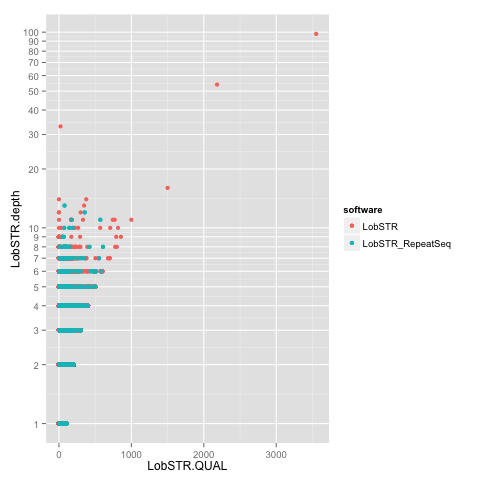

In [44]:
%%R
p = ggplot(all.data[all.data$software %in% c('LobSTR', 'LobSTR_RepeatSeq'),], aes(colour=software)) +
    geom_point(aes(x = LobSTR.QUAL, y = LobSTR.depth)) +
    geom_point(data = LobSTR.RepeatSeq, aes(x = LobSTR.QUAL, y = LobSTR.depth)) +
    #coord_cartesian(xlim = c(0,1000), ylim = c(1,40)) +
    scale_y_log10(breaks= c(seq(1, 9, 1), seq(10, 100, 10)) )
print(p)

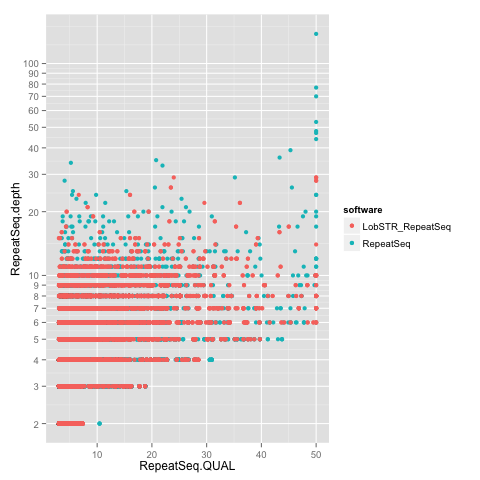

In [45]:
%%R
p = ggplot(all.data[all.data$software %in% c('RepeatSeq', 'LobSTR_RepeatSeq'),], aes(colour=software)) +
    geom_point(aes(x = RepeatSeq.QUAL, y = RepeatSeq.depth)) +
    geom_point(data = LobSTR.RepeatSeq, aes(x = RepeatSeq.QUAL, y = RepeatSeq.depth)) +

    scale_y_log10(breaks= c(seq(1, 9, 1), seq(10, 100, 10)) )
print(p)

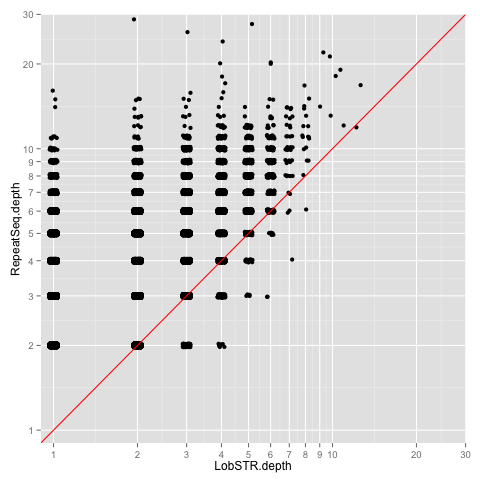

In [46]:
%%R
p = ggplot(LobSTR.RepeatSeq) +
    geom_jitter(aes(x = LobSTR.depth, y = RepeatSeq.depth)) +
    coord_cartesian(xlim=c(.9,30), ylim=c(.9,30)) +
    scale_y_log10(breaks= c(seq(1, 9, 1), seq(10, 100, 10)) ) +
    scale_x_log10(breaks= c(seq(1, 9, 1), seq(10, 100, 10)) ) +
    geom_abline(intercept = 0, slope = 1, colour = 'red')
print(p)

RepeatSeq has higher depth for each locus that they both genotype.

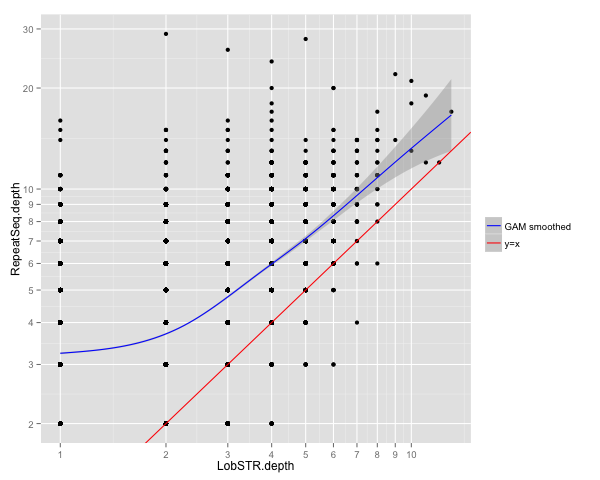

In [47]:
%%R -w 600
p = ggplot(LobSTR.RepeatSeq) +
    geom_point(aes(x = LobSTR.depth, y = RepeatSeq.depth)) +
    #loess is just too slow, so using the default gam formula (but stating it explicitly)
    stat_smooth(aes(x = LobSTR.depth, y = RepeatSeq.depth, colour = "GAM smoothed"), 
                method = 'gam', formula = y ~ s(x, bs = "cs")) +
    geom_abline(aes(colour = "y=x"), intercept = 0, slope = 1) +
    scale_y_log10(breaks= c(seq(1, 9, 1), seq(10, 100, 10)) ) +
    scale_x_log10(breaks= c(seq(1, 9, 1), seq(10, 100, 10)) ) +
    
    scale_colour_manual("", 
                      breaks = c("GAM smoothed", "y=x"),
                      values = c("blue", "red")) 

print(p)



Using software as id variables


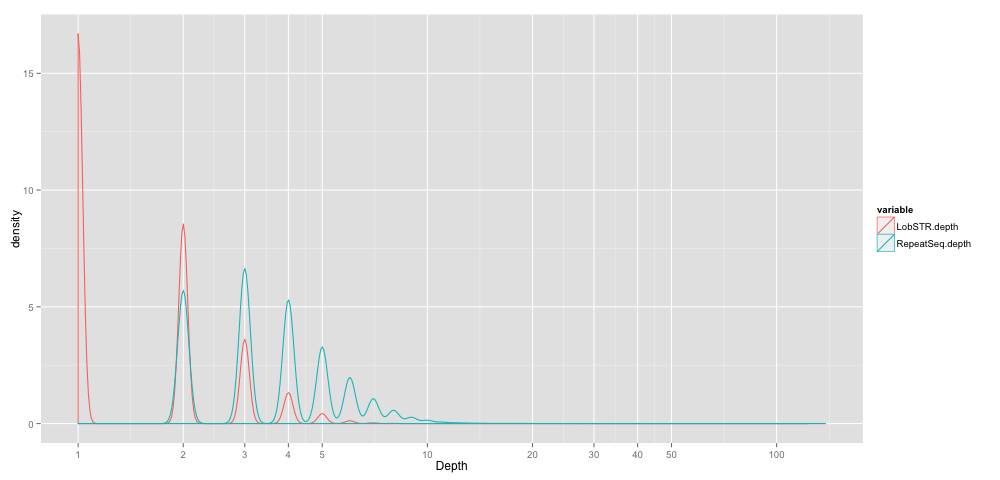

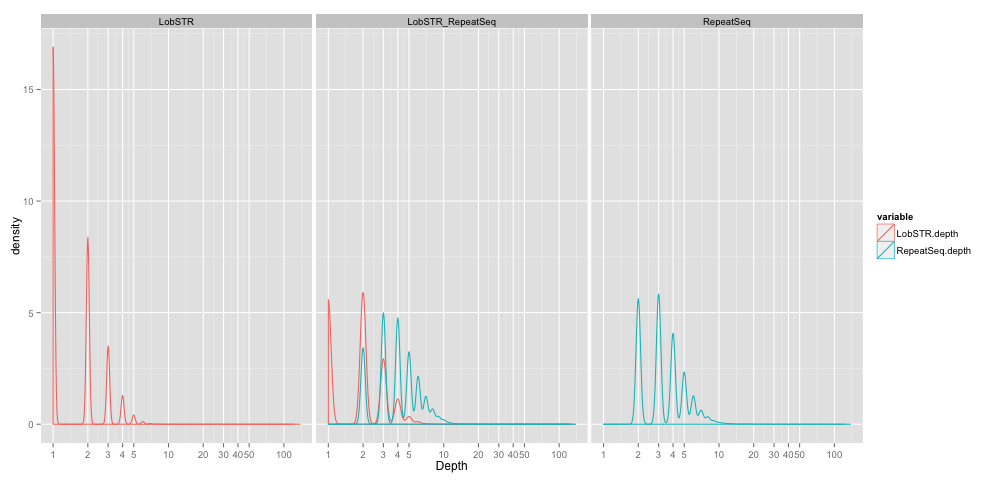

In [48]:
%%R -w 1000
temp.data = all.data[c('LobSTR.depth', 'RepeatSeq.depth', 'software')]
temp.data = melt(temp.data)
p = ggplot(temp.data) +
        geom_density(aes(x = value,
                         colour = variable)) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 50, 10), 100)) + 
    xlab("Depth")
print(p)

p = ggplot(temp.data) +
        geom_density(aes(x = value,
                         colour = variable)) +
    facet_wrap( ~ software) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 50, 10), 100)) + 
    xlab("Depth")
print(p)

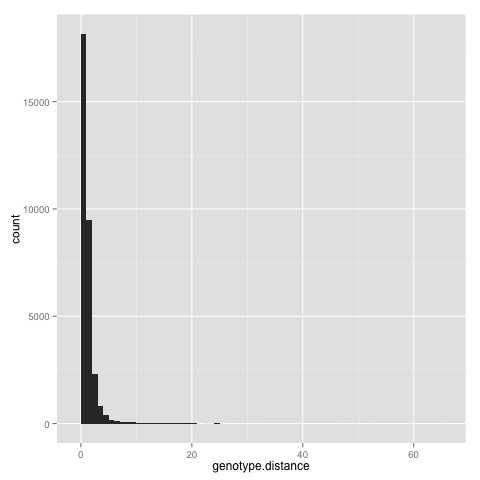

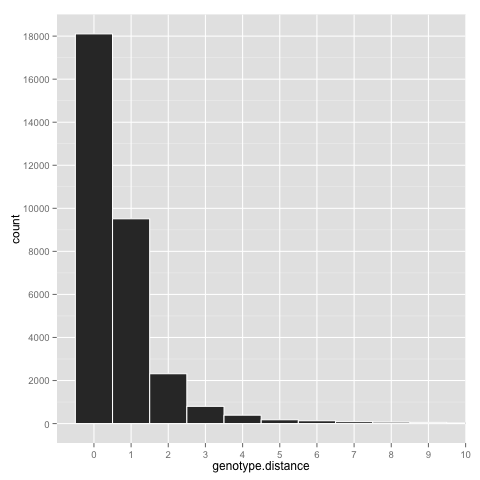

In [49]:
%%R 
p = ggplot(LobSTR.RepeatSeq) +
        geom_histogram(aes(x = genotype.distance), binwidth = 1) 
print(p)

p = ggplot(LobSTR.RepeatSeq) +
        geom_histogram(aes(x = genotype.distance), binwidth = 1, origin = -0.5, colour = "white") +
        coord_cartesian(xlim=c(-1,10)) +
        scale_x_discrete(breaks= seq(0, 10, 1)) +
        scale_y_continuous(breaks= seq(0, 20000, 2000))
        #scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 50, 10), 100))
print(p)


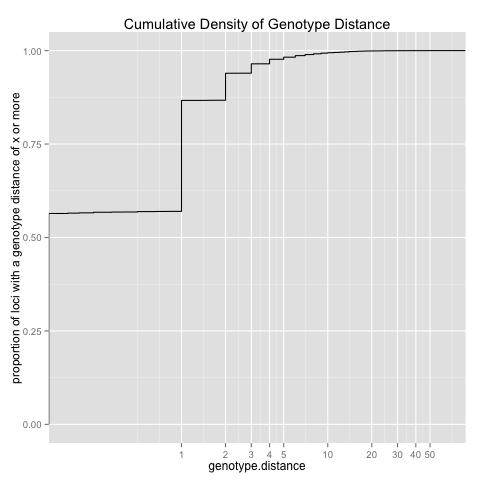

In [50]:
%%R

# cumulative plot
p = ggplot() +
        stat_ecdf(data = LobSTR.RepeatSeq, aes(x = genotype.distance)) +
        scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 50, 10))) + 
        labs(title="Cumulative Density of Genotype Distance", 
             y="proportion of loci with a genotype distance of x or more") 
print(p)



In [51]:
%%R
c(0:2,'3+')

[1] "0"  "1"  "2"  "3+"


In [52]:
%%R
summary(all.data$RepeatSeq.genotypecategory)

          0/1    1/1    1/2 
769052  50033  15838  10053 


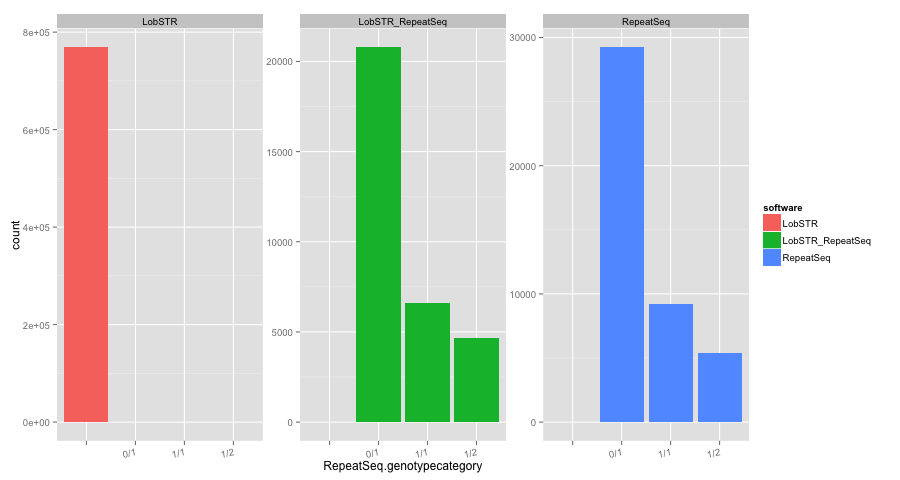

In [53]:
%%R -w 900
p = ggplot(all.data, aes(x = RepeatSeq.genotypecategory, fill=software)) +
    geom_histogram() + facet_wrap( ~ software, scales="free_y") +
    theme(axis.text.x = element_text(angle = 10, hjust = 1))
print(p)

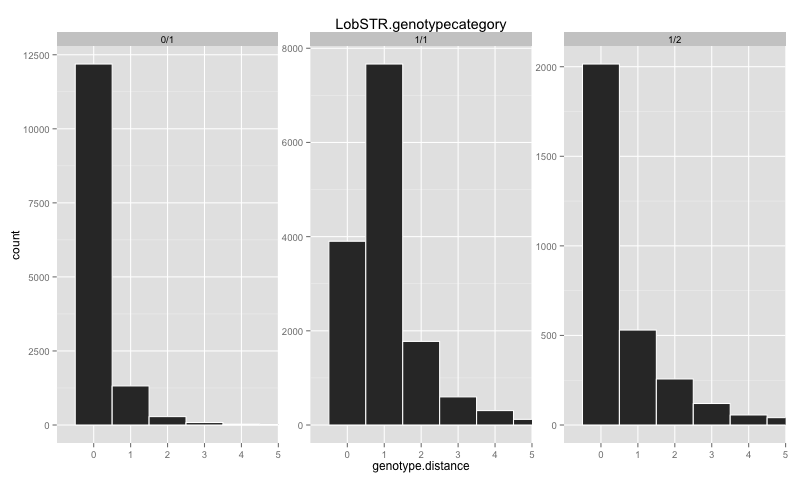

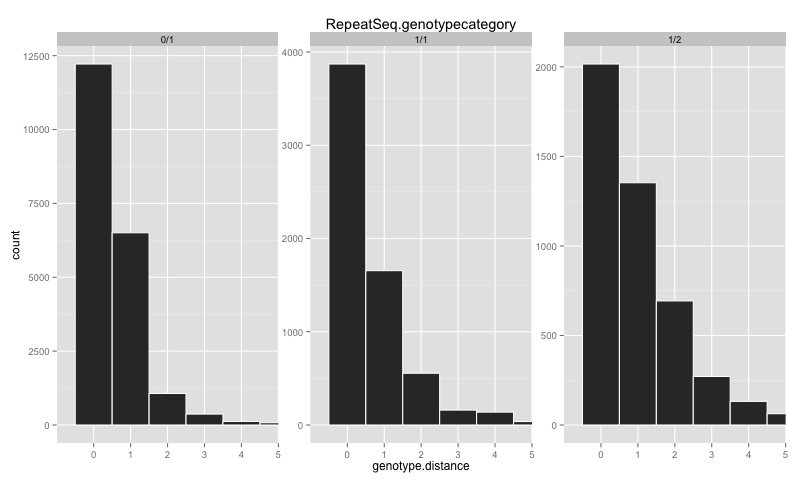

In [54]:
%%R -w 800
p = ggplot(LobSTR.RepeatSeq) +
        geom_histogram(aes(x = genotype.distance), binwidth = 1, origin = -0.5, colour = "white") +
        coord_cartesian(xlim=c(-1,5)) +
        scale_x_discrete(breaks= seq(0, 5, 1)) +
        facet_wrap( ~ LobSTR.genotypecategory, scales="free") +
        labs(title="LobSTR.genotypecategory")
print(p)

p = ggplot(LobSTR.RepeatSeq) +
        geom_histogram(aes(x = genotype.distance), binwidth = 1, origin = -0.5, colour = "white") +
        coord_cartesian(xlim=c(-1,5)) +
        scale_x_discrete(breaks= seq(0, 5, 1)) +
        facet_wrap( ~ RepeatSeq.genotypecategory, scales="free") +
        labs(title="RepeatSeq.genotypecategory")
print(p)

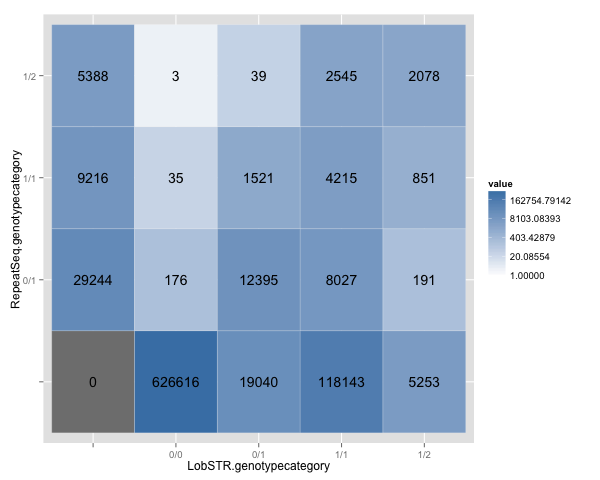

In [55]:
%%R -w 600
temp.data = all.data[c('LobSTR.genotypecategory', 'RepeatSeq.genotypecategory')]
temp.data = table(temp.data)
temp.data = melt(temp.data)

p1 = ggplot(temp.data, aes(LobSTR.genotypecategory, RepeatSeq.genotypecategory)) +
    geom_tile(aes(fill = value), colour = "white") +
    scale_fill_gradient(low = "white", high = "steelblue", trans = "log", limits=c(1, max(temp.data$value)))

# Get data - this includes counts and x,y coordinates
newdat = ggplot_build(p1)$data[[1]]
#print(newdat)
# add in text labels
p2 = p1 + geom_text(data=newdat, aes((xmin + xmax)/2, (ymin + ymax)/2,
                  label=temp.data$value))

print(p2)

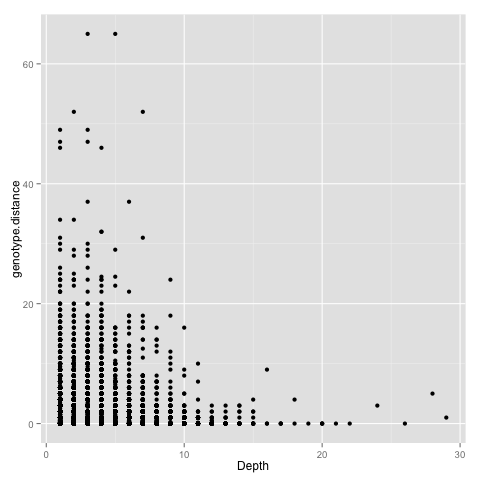

In [56]:
%%R

p = ggplot(LobSTR.RepeatSeq) +
    geom_point(aes(x = LobSTR.depth, y = genotype.distance)) +
    geom_point(aes(x = RepeatSeq.depth, y = genotype.distance)) + 
    xlab("Depth") 
print(p)

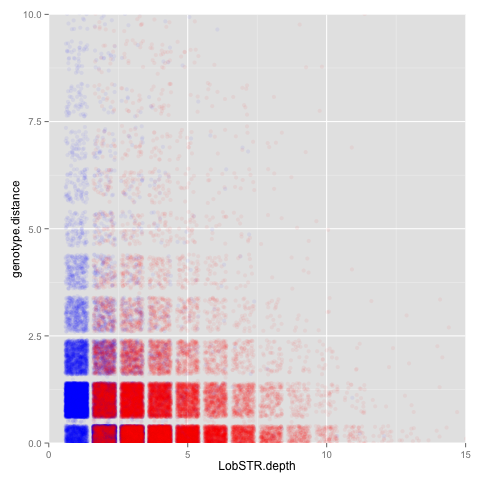

In [57]:
%%R
point.size = 2
j.w = 0.4
j.h = 0.4
alpha = 0.05

p = ggplot(LobSTR.RepeatSeq) +
    geom_point(aes(x = LobSTR.depth, y = genotype.distance), 
               colour = 'blue', alpha=alpha, size = point.size, position = position_jitter(w = j.w, h = j.h) ) +
    geom_point(aes(x = RepeatSeq.depth, y = genotype.distance), 
               colour = 'red', alpha=alpha, size = point.size, position = position_jitter(w = j.w, h = j.h) ) + 
    coord_cartesian(xlim=c(0,15), ylim=c(0,10))

#+
    #geom_jitter(aes(x = LobSTR.depth, y = genotype.distance), colour = 'blue', alpha=0.01, size = point.size)
print(p)


In [95]:
%%R

# Does QUAL predict concordance?
lm.LobSTR = lm(genotype.distance ~ LobSTR.QUAL, data = LobSTR.RepeatSeq)
print(summary(lm.LobSTR))

lm.RepeatSeq = lm(genotype.distance ~ RepeatSeq.QUAL, data = LobSTR.RepeatSeq)
print(summary(lm.RepeatSeq))


Call:
lm(formula = genotype.distance ~ LobSTR.QUAL, data = LobSTR.RepeatSeq)

Residuals:
   Min     1Q Median     3Q    Max 
-7.515 -0.646 -0.496  0.383 64.398 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.3431277  0.0131471   26.10   <2e-16 ***
LobSTR.QUAL 0.0117991  0.0002439   48.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.708 on 31860 degrees of freedom
Multiple R-squared:  0.06842,	Adjusted R-squared:  0.06839 
F-statistic:  2340 on 1 and 31860 DF,  p-value: < 2.2e-16


Call:
lm(formula = genotype.distance ~ RepeatSeq.QUAL, data = LobSTR.RepeatSeq)

Residuals:
   Min     1Q Median     3Q    Max 
-0.852 -0.809 -0.673  0.190 64.163 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.912641   0.017129  53.282   <2e-16 ***
RepeatSeq.QUAL -0.019970   0.002092  -9.548   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’

In [149]:
%%R
same.genotype = LobSTR.RepeatSeq$LobSTR.QUAL[LobSTR.RepeatSeq$identical.genotype == "True"]
diff.genotype = LobSTR.RepeatSeq$LobSTR.QUAL[LobSTR.RepeatSeq$identical.genotype == "False"]
wilcox.test(x = same.genotype, y = diff.genotype,
            alternative = c("greater"),
            paired = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  same.genotype and diff.genotype
W = 94790000, p-value = 1
alternative hypothesis: true location shift is greater than 0



In [150]:
%%R
same.genotype = LobSTR.RepeatSeq$RepeatSeq.QUAL[LobSTR.RepeatSeq$identical.genotype == "True"]
diff.genotype = LobSTR.RepeatSeq$RepeatSeq.QUAL[LobSTR.RepeatSeq$identical.genotype == "False"]
wilcox.test(x = same.genotype, y = diff.genotype,
            alternative = c("greater"),
            paired = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  same.genotype and diff.genotype
W = 152870000, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0



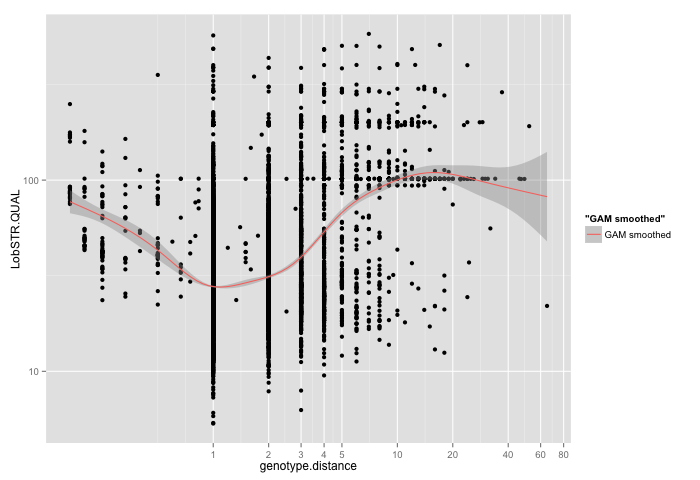

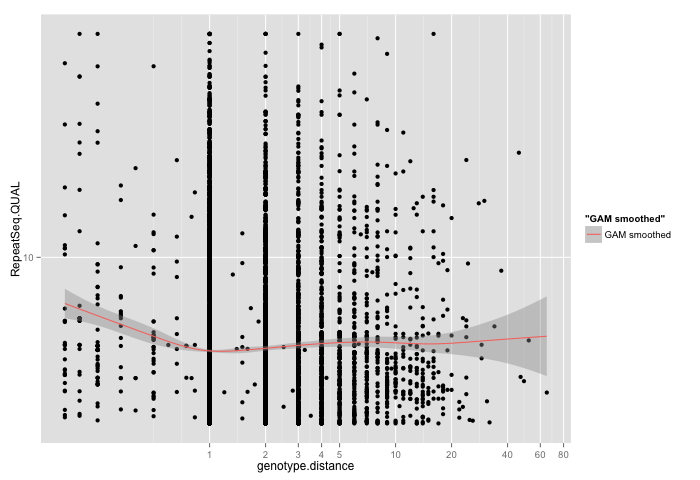

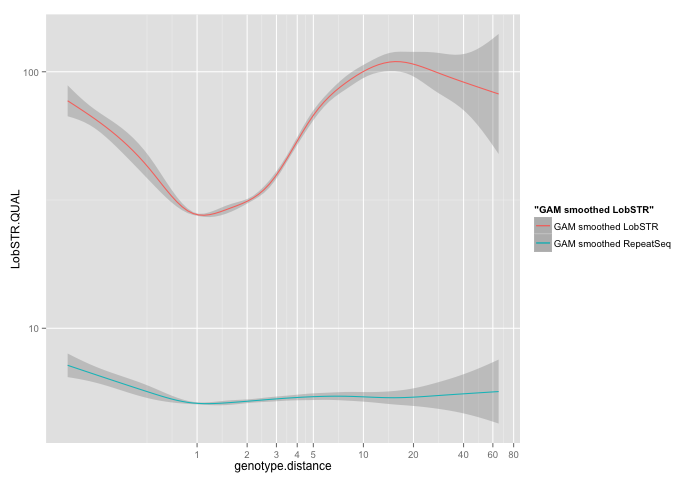

In [137]:
%%R -w 700
temp.data = LobSTR.RepeatSeq[LobSTR.RepeatSeq$genotype.distance > 0,] # filter out zeros
#temp.data = LobSTR.RepeatSeq

p = ggplot(temp.data) +
    geom_point(aes(y = LobSTR.QUAL, x = genotype.distance)) +
    stat_smooth(aes(y = LobSTR.QUAL, x = genotype.distance, colour = "GAM smoothed"), 
                method = 'gam', formula = y ~ s(x, bs = "cs")) +
    scale_y_log10() + scale_x_log10(breaks= c(seq(1, 5, 1), 10, seq(20, 90, 20)))
print(p)


p = ggplot(temp.data) +
    geom_point(aes(y = RepeatSeq.QUAL, x = genotype.distance)) +
    stat_smooth(aes(y = RepeatSeq.QUAL, x = genotype.distance, colour = "GAM smoothed"), 
                method = 'gam', formula = y ~ s(x, bs = "cs")) +
    scale_y_log10() + scale_x_log10(breaks= c(seq(1, 5, 1), 10, seq(20, 90, 20)))
print(p)

p = ggplot(temp.data) +
    stat_smooth(aes(y = LobSTR.QUAL, x = genotype.distance, colour = "GAM smoothed LobSTR"), 
                method = 'gam', formula = y ~ s(x, bs = "cs")) +
    stat_smooth(aes(y = RepeatSeq.QUAL, x = genotype.distance, colour = "GAM smoothed RepeatSeq"), 
                method = 'gam', formula = y ~ s(x, bs = "cs")) +
    scale_y_log10() + scale_x_log10(breaks= c(seq(1, 5, 1), 10, seq(20, 90, 20)))
print(p)

No id variables; using all as measure variables


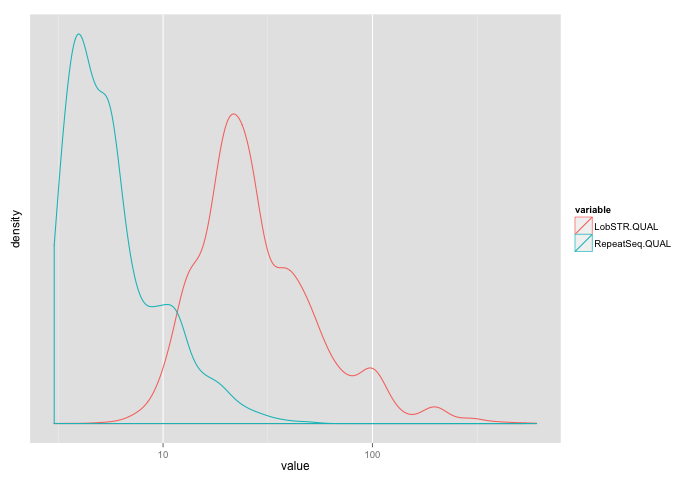

In [145]:
%%R -w 700
temp.data = LobSTR.RepeatSeq[c('LobSTR.QUAL', 'RepeatSeq.QUAL')]
temp.data = melt(temp.data)

p = ggplot(temp.data) +
geom_density(aes(x = value,y = ..density..,
                         colour = variable), adjust = 2) +
    scale_y_continuous(breaks=NULL) +
    scale_x_log10()#breaks= c(seq(1, 5, 1), seq(10, 40, 10), 100, 200)) + 
    labs(title="", x="") 
print(p)

In [60]:
%%R
levels(LobSTR.RepeatSeq$identical.genotype)

[1] ""      "False" "True" 


In [93]:
%%R
summary(LobSTR.RepeatSeq$LobSTR.QUAL)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.305  18.340  24.940  36.960  39.890 607.900 


In [94]:
%%R
summary(LobSTR.RepeatSeq$RepeatSeq.QUAL)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.021   3.850   5.118   6.683   7.442  50.000 


In [61]:
%%R

# Does QUAL predict concordance?
x = glm(identical.genotype ~ LobSTR.QUAL, data = LobSTR.RepeatSeq, family = 'binomial')
print(summary(x))
x = glm(identical.genotype ~ RepeatSeq.QUAL, data = LobSTR.RepeatSeq, family = 'binomial')
print(summary(x))


Call:
glm(formula = identical.genotype ~ LobSTR.QUAL, family = "binomial", 
    data = LobSTR.RepeatSeq)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.304  -1.268   1.066   1.085   2.056  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.312165   0.015808   19.75   <2e-16 ***
LobSTR.QUAL -0.003781   0.000303  -12.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 43934  on 31861  degrees of freedom
Residual deviance: 43768  on 31860  degrees of freedom
AIC: 43772

Number of Fisher Scoring iterations: 4


Call:
glm(formula = identical.genotype ~ RepeatSeq.QUAL, family = "binomial", 
    data = LobSTR.RepeatSeq)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3734  -1.1962   0.9258   1.1344   1.1933  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.216957   0.0

Error in dev.off() : 
  QuartzBitmap_Output - unable to open file '/var/folders/3k/cmmjqngd2ns2rk37hy92t3940000gr/T/tmprcly4n7k/Rplots001.png'


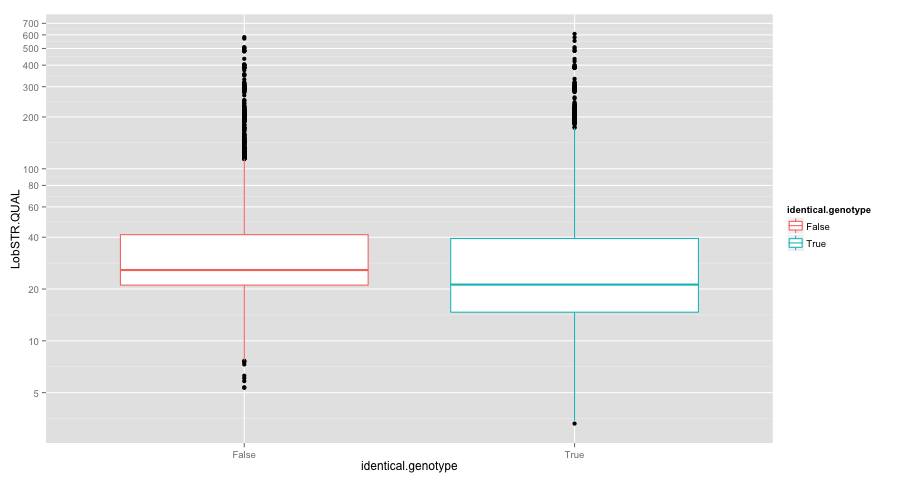

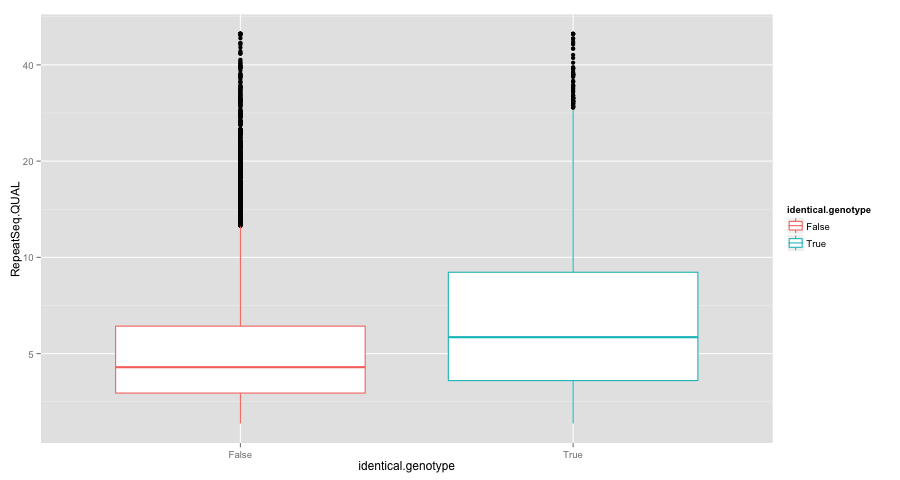

In [98]:
%%R -w 900

p = ggplot(LobSTR.RepeatSeq) +
    geom_boxplot(aes(x = identical.genotype, y=LobSTR.QUAL, color=identical.genotype)) +
    #geom_boxplot(aes(x = identical.genotype, y=LobSTR.QUAL, color=identical.genotype)) +
    scale_y_log10(breaks= c(5, 10, seq(20, 90, 20), seq(100, 1000, 100)))
print(p)

p = ggplot(LobSTR.RepeatSeq) +
    geom_boxplot(aes(x = identical.genotype, y=RepeatSeq.QUAL, color=identical.genotype)) +
    scale_y_log10(breaks= c(5, 10, seq(20, 90, 20), seq(100, 1000, 100)))
print(p)

[1] 3


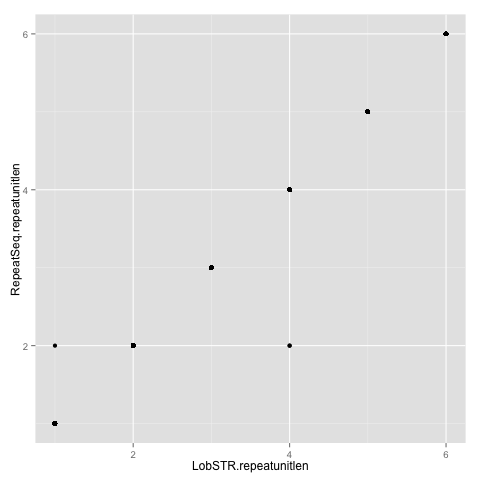

In [63]:
%%R
p = ggplot(LobSTR.RepeatSeq) + 
    geom_point(aes(x=LobSTR.repeatunitlen, y=RepeatSeq.repeatunitlen))
print(p)

# How many loci don't have the same repeat unit length?
sum(!(LobSTR.RepeatSeq$LobSTR.repeatunitlen == LobSTR.RepeatSeq$RepeatSeq.repeatunitlen))

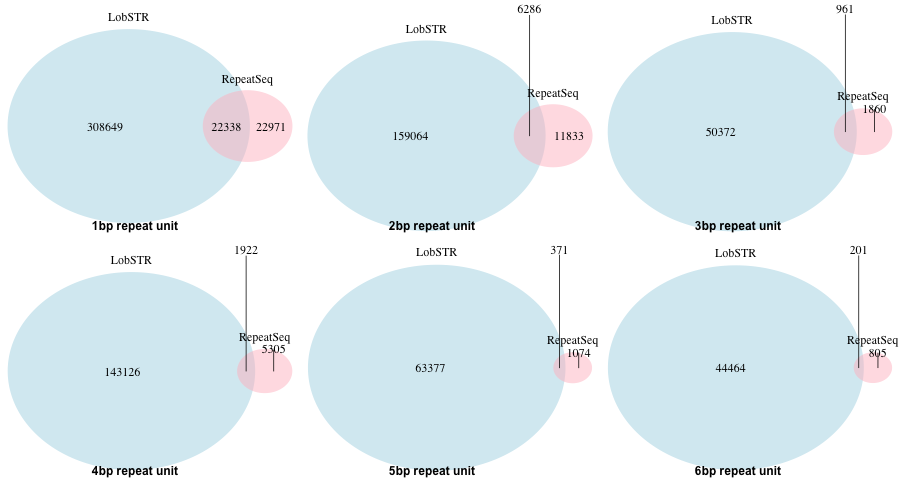

In [64]:
%%R -w 900

rep.unit.venn = function(data, rep.unit){
    temp.data = data[data$LobSTR.repeatunitlen == rep.unit | data$RepeatSeq.repeatunitlen == rep.unit,]
    venn.table = table(temp.data$software)
    intersection = venn.table['LobSTR_RepeatSeq']
    LobSTR_only = venn.table['LobSTR']
    RepeatSeq_only = venn.table['RepeatSeq']

    p = draw.pairwise.venn(LobSTR_only + intersection, RepeatSeq_only + intersection, intersection, category = c("LobSTR", "RepeatSeq"),
        lty = rep("blank", 2), fill = c("light blue", "pink"), main='test',
        alpha = rep(0.5, 2), cat.dist = rep(0.025, 2),  cat.pos=c(0,0), 
                           ind = FALSE) 
    return(p)
}

p1 = rep.unit.venn(all.data, 1)
p2 = rep.unit.venn(all.data, 2)
p3 = rep.unit.venn(all.data, 3)
p4 = rep.unit.venn(all.data, 4)
p5 = rep.unit.venn(all.data, 5)
p6 = rep.unit.venn(all.data, 6)

library(gridExtra)
grid.arrange(gTree(children=p1), gTree(children=p2), gTree(children=p3), 
             gTree(children=p4), gTree(children=p5), gTree(children=p6), 
             ncol=3, nrow=2)
grid.text("1bp repeat unit", x=0.15, y=.53, gp=gpar(fontface='bold'))
grid.text("2bp repeat unit", x=0.48, y=.53, gp=gpar(fontface='bold'))
grid.text("3bp repeat unit", x=0.82, y=.53, gp=gpar(fontface='bold'))
grid.text("4bp repeat unit", x=0.15, y=.02, gp=gpar(fontface='bold'))
grid.text("5bp repeat unit", x=0.48, y=.02, gp=gpar(fontface='bold'))
grid.text("6bp repeat unit", x=0.82, y=.02, gp=gpar(fontface='bold'))


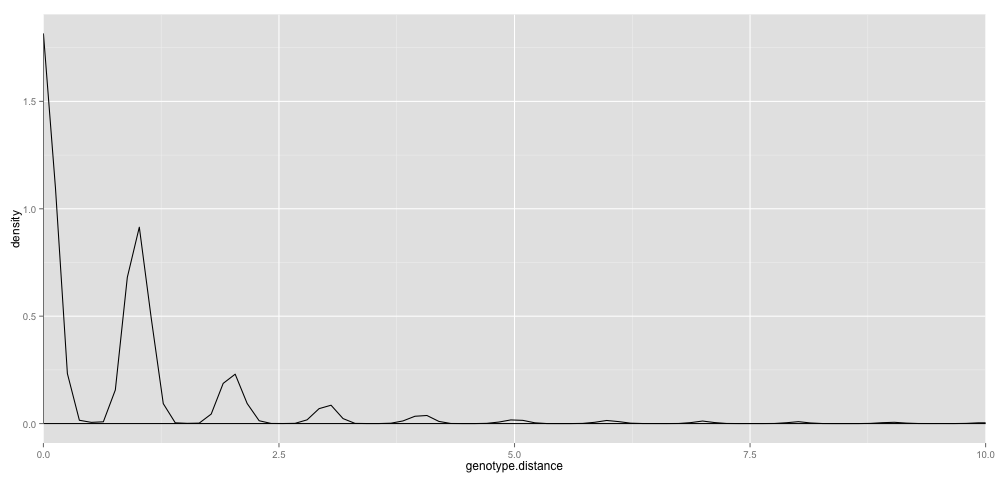

In [65]:
%%R -w 1000
p = ggplot(LobSTR.RepeatSeq) +
        geom_density(aes(x = genotype.distance)) + coord_cartesian(xlim=c(0,10))
    #facet_wrap( ~ software) +
    #scale_x_log10(breaks= c(seq(0, 5, 1), seq(10, 50, 10), 100)) #+ 
    #scale_x_log10()
    #scale_x_continuous(formatter='log10')
#scale_x_continuous(breaks = log_trans())
    #xlab("Depth")
print(p)

Hypothesis:
LobSTR can genotype longer alleles and alleles that are more different in length from the reference (in bp)

Plot bp difference between allele length and the reference (i.e. indel length)

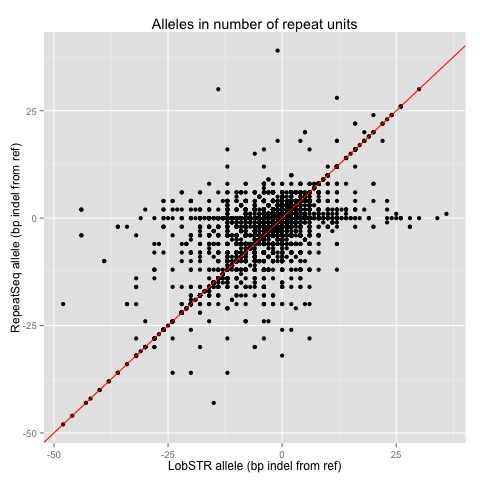

In [66]:
%%R
# Two dots for each genotype at each locus: small allele against small, large against large.
p = ggplot(LobSTR.RepeatSeq) +
    geom_point(aes(x = LobSTR.indel1, y = RepeatSeq.indel1)) +
    geom_point(aes(x = LobSTR.indel2, y = RepeatSeq.indel2)) +
    geom_abline(intercept = 0, slope = 1, colour = 'red') +
    labs(title="Alleles in number of repeat units", 
         x='LobSTR allele (bp indel from ref)', y='RepeatSeq allele (bp indel from ref)')
print(p)

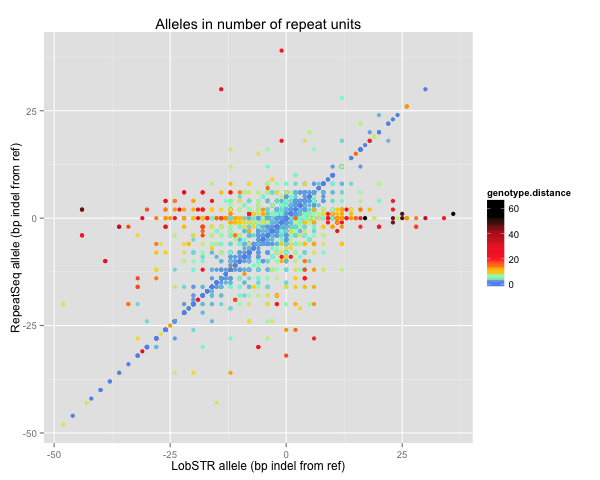

In [67]:
%%R -w 600
p = ggplot(LobSTR.RepeatSeq, aes(colour=genotype.distance)) +
    geom_point(aes(x = LobSTR.indel1, y = RepeatSeq.indel1)) +
    geom_point(aes(x = LobSTR.indel2, y = RepeatSeq.indel2)) +
    scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
                                     'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
                                     'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
                                     'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units", 
         x='LobSTR allele (bp indel from ref)', y='RepeatSeq allele (bp indel from ref)')
print(p)

Hypothesis:
LobSTR calls (spurious) homozygotes with only one read

Density/histogram of depth
Calls in LobSTR only vs intersection
homozygous calls vs not
facet_grid(LobSTR.genotypecategory ~ same.genotype)

Using software, LobSTR.genotypecategory, RepeatSeq.genotypecategory as id variables


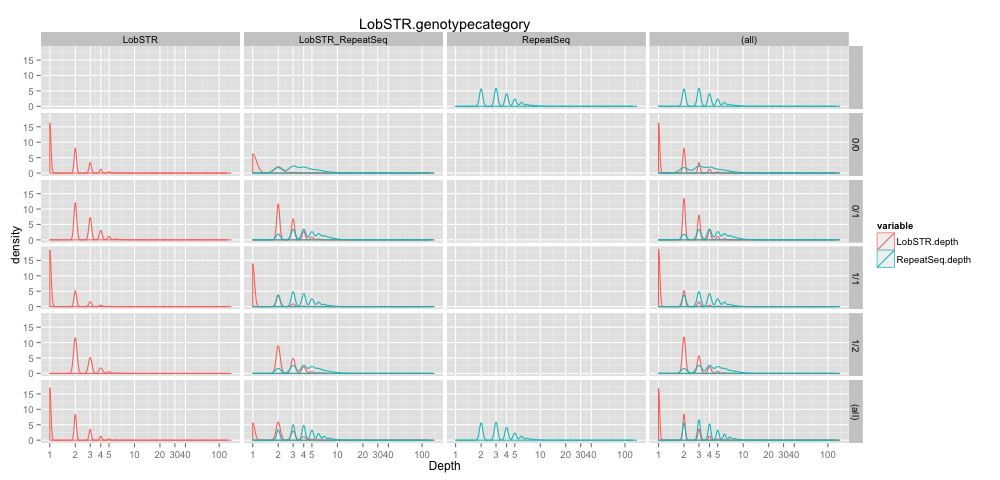

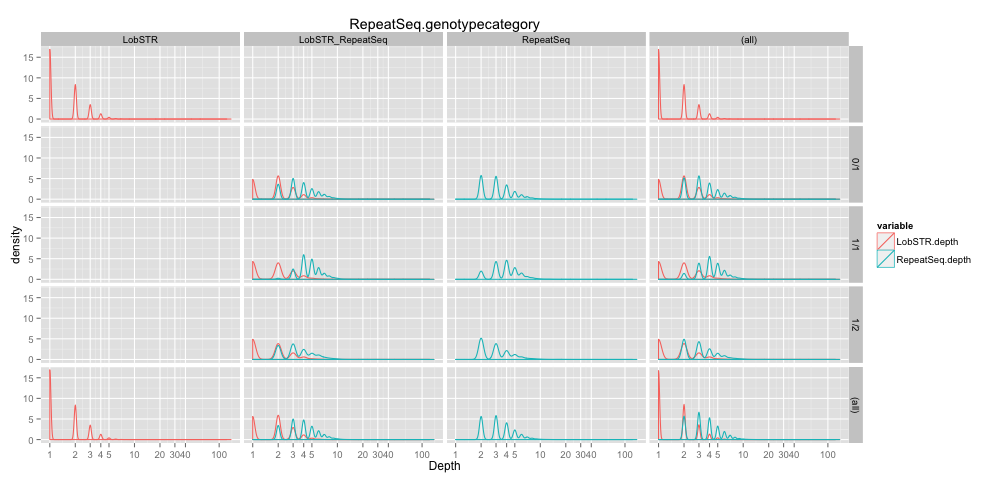

In [68]:
%%R -w 1000
temp.data = all.data[c('LobSTR.depth', 'RepeatSeq.depth', 'software', 'LobSTR.genotypecategory', 'RepeatSeq.genotypecategory')]
temp.data = melt(temp.data)

p = ggplot(temp.data) +
        geom_density(aes(x = value,
                         colour = variable)) +
    facet_grid(LobSTR.genotypecategory ~ software, margins=TRUE) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 40, 10), 100)) + 
    labs(title="LobSTR.genotypecategory", x="Depth") 
print(p)

p = ggplot(temp.data) +
        geom_density(aes(x = value,
                         colour = variable)) +
    facet_grid(RepeatSeq.genotypecategory ~ software, margins=TRUE) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 40, 10), 100)) + 
    labs(title="RepeatSeq.genotypecategory", x="Depth") 
print(p)



In [69]:
%%R
temp.data = all.data[c( 'software', 'LobSTR.genotypecategory', 'RepeatSeq.genotypecategory')]
temp.data = melt(temp.data)

head(temp.data)

Using software, LobSTR.genotypecategory, RepeatSeq.genotypecategory as id variables
   software LobSTR.genotypecategory RepeatSeq.genotypecategory
1 RepeatSeq                                                1/1
2    LobSTR                     1/2                           
3    LobSTR                     1/2                           
4    LobSTR                     0/0                           
5    LobSTR                     0/0                           
6    LobSTR                     0/0                           


Using genotype.distance.group, LobSTR.genotypecategory, RepeatSeq.genotypecategory as id variables


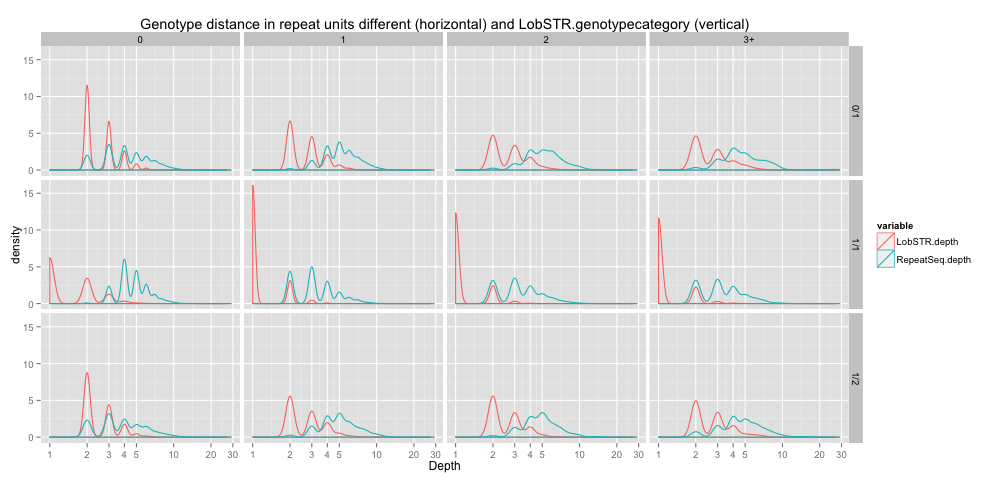

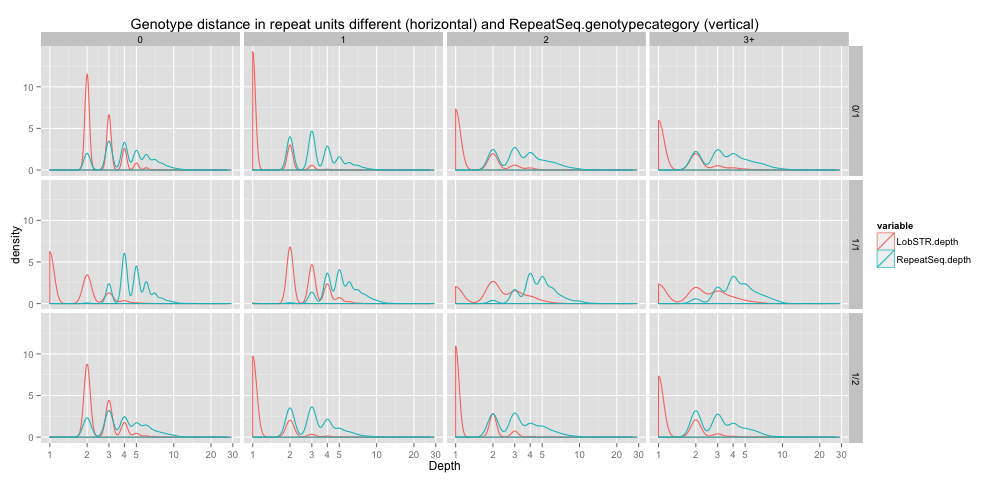

In [70]:
%%R -w 1000

temp.data = LobSTR.RepeatSeq[c('LobSTR.depth', 'RepeatSeq.depth', 'genotype.distance.group', 'LobSTR.genotypecategory', 'RepeatSeq.genotypecategory')]
temp.data = melt(temp.data)

p = ggplot(temp.data) +
        geom_density(aes(x = value,
                         colour = variable)) +
    facet_grid(LobSTR.genotypecategory ~ genotype.distance.group) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 40, 10), 100)) + 
    labs(title="Genotype distance in repeat units different (horizontal) and LobSTR.genotypecategory (vertical)", x="Depth") 
print(p)

p = ggplot(temp.data) +
        geom_density(aes(x = value,
                         colour = variable)) +
    facet_grid(RepeatSeq.genotypecategory ~ genotype.distance.group) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 40, 10), 100)) + 
    labs(title="Genotype distance in repeat units different (horizontal) and RepeatSeq.genotypecategory (vertical)", x="Depth") 
print(p)

In [71]:
%%R
# Density plot: ref allelele length for each genotyper. Also line for all ref alleles

temp.lobstr = all.data[all.data$software == 'LobSTR_RepeatSeq' | all.data$software == 'LobSTR',]
temp.lobstr = temp.lobstr[!temp.lobstr$LobSTR.genotype == '0/0',] # Remove loci where LobSTR called 0/0 genotype
temp.repeatseq = all.data[all.data$software == 'LobSTR_RepeatSeq' | all.data$software == 'RepeatSeq',]
all.refallelelen = all.data[,c('LobSTR.refallelelen', 'RepeatSeq.refallelelen')]
all.refallelelen = apply(all.refallelelen, 1, max, na.rm = T)

LobSTR calls more variants at longer loci, RepeatSeq calls more at shorter loci.

No id variables; using all as measure variables


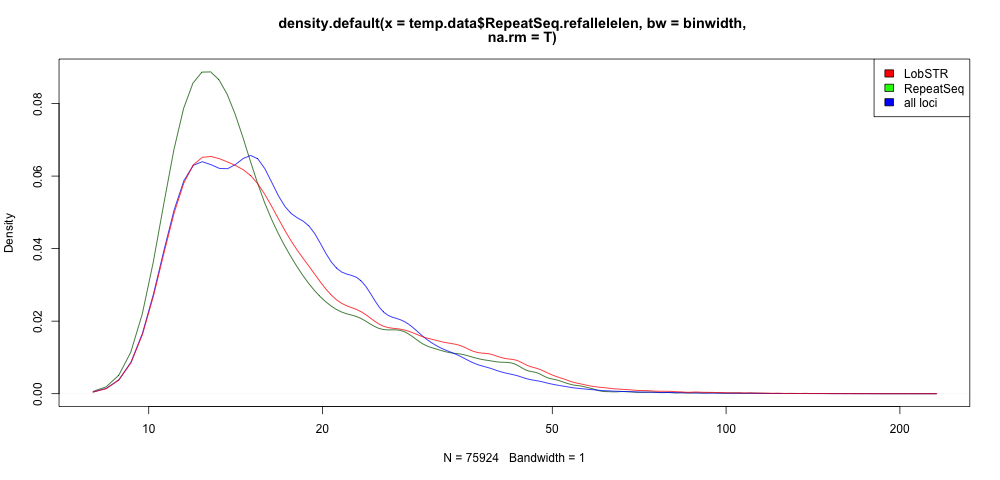

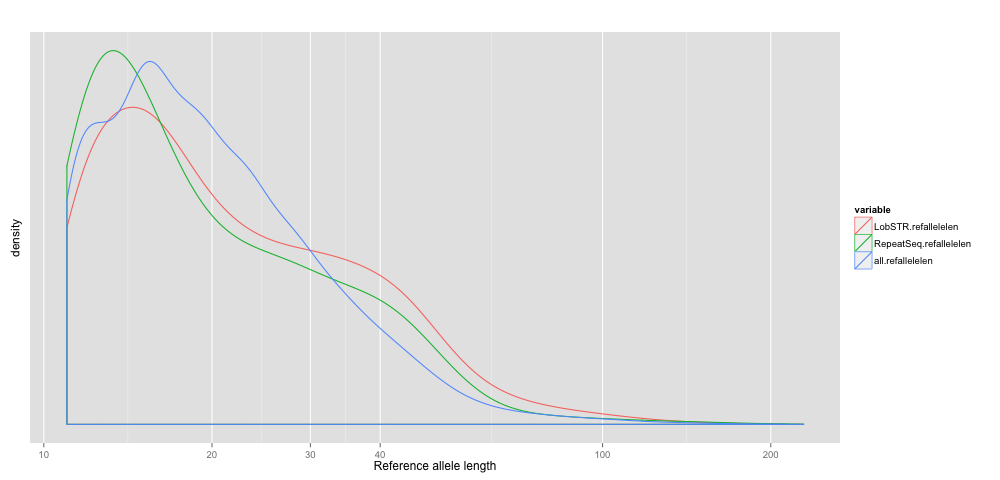

In [72]:
%%R -w 1000
temp.data = cbind(all.data[c('LobSTR.refallelelen', 'RepeatSeq.refallelelen')], all.refallelelen)
temp.data$LobSTR.refallelelen[all.data$LobSTR.genotype == '0/0'] = NA
binwidth = 1
plot(density(temp.data$RepeatSeq.refallelelen, na.rm = T, bw = binwidth), col="darkgreen", log="x")
lines(density(temp.data$all.refallelelen, na.rm = T, bw = binwidth), col="blue", log="x")
lines(density(temp.data$LobSTR.refallelelen, na.rm = T, bw = binwidth), col="red", log="x")
legend("topright", legend = c('LobSTR', 'RepeatSeq',  'all loci'), fill= c('red', 'green', 'blue'))

###XXX

temp.data = melt(temp.data)

p = ggplot(temp.data) +
geom_density(aes(x = value,y = ..density..,
                         colour = variable), adjust = 3) +
    #geom_freqpoly(aes(x = value, y = ..density..,
    #                     colour = variable)) +
    scale_y_continuous(breaks=NULL) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 40, 10), 100, 200)) + 
    labs(title="", x="Reference allele length") 
print(p)

## LobSTR vs. RepeatSeq - both run on LobSTR bams

In [73]:
dirname = '/Users/hd_vlsci/Documents/git/STR-pipelines/data/'
lobstr = 'NA20845_LobSTR.renamed.target.trimmed.vcf' # All normalised LobSTR calls
repeatseq = 'NA20845_RepeatSeq_LobSTRbam.renamed.trimmed.vcf' # All normalised RepeatSeq calls run on LobSTR bam

compare_genotypes(dirname+lobstr, dirname+repeatseq, 'LobSTR_RepeatSEQ-LobSTRbam_genotypes.csv')

In [74]:
%%R
# Load data
all.data2 = read.csv("LobSTR_RepeatSEQ-LobSTRbam_genotypes.csv")

genotype.distance.group
    0     1     2    3+ 
19616  1812   447   415 


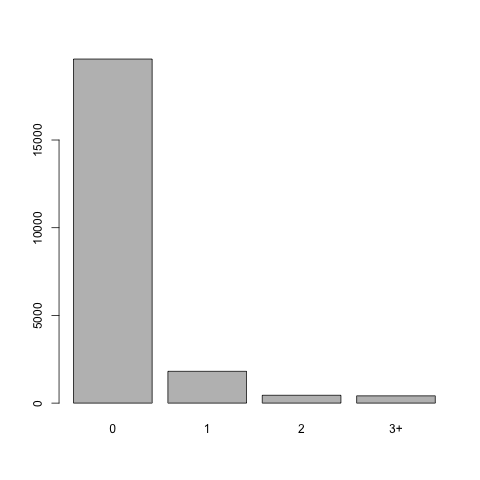

In [75]:
%%R
LobSTR.RepeatSeq2 = all.data2[all.data2$software == 'LobSTR_RepeatSeq',] # Filter to loci shared by both
LobSTR.RepeatSeq2 = LobSTR.RepeatSeq2[!LobSTR.RepeatSeq2$LobSTR.genotype == '0/0',] # Remove loci where LobSTR called 0/0 genotype

# Categorise Genotype Distance
genotype.distance.group = cut(LobSTR.RepeatSeq2$genotype.distance, c(-Inf, seq(0, 2, 1), Inf), labels=c(0:2,'3+') )
LobSTR.RepeatSeq2 = cbind(LobSTR.RepeatSeq2, genotype.distance.group)

print(table(genotype.distance.group))
barplot(table(genotype.distance.group))

(polygon[GRID.polygon.5140], polygon[GRID.polygon.5141], polygon[GRID.polygon.5142], polygon[GRID.polygon.5143], text[GRID.text.5144], text[GRID.text.5145], lines[GRID.lines.5146], text[GRID.text.5147], lines[GRID.lines.5148], text[GRID.text.5149], text[GRID.text.5150]) 


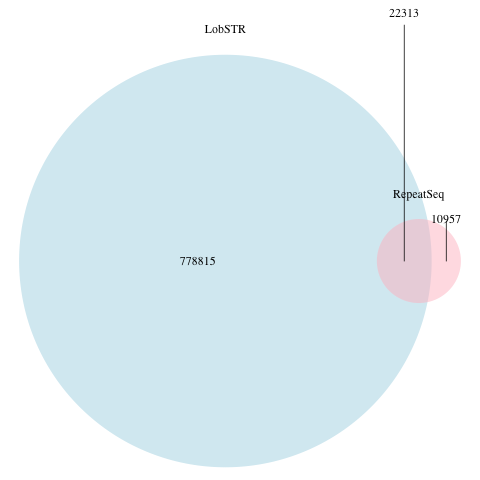

In [76]:
%%R
# Venn with all data
venn.table = table(all.data2$software)
intersection = venn.table['LobSTR_RepeatSeq']
LobSTR_only = venn.table['LobSTR']
RepeatSeq_only = venn.table['RepeatSeq']
plot.venn(intersection, LobSTR_only, RepeatSeq_only)

(polygon[GRID.polygon.5151], polygon[GRID.polygon.5152], polygon[GRID.polygon.5153], polygon[GRID.polygon.5154], text[GRID.text.5155], text[GRID.text.5156], text[GRID.text.5157], text[GRID.text.5158], text[GRID.text.5159]) 


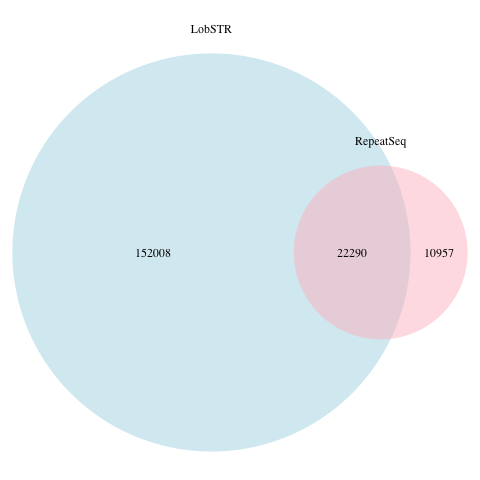

In [77]:
%%R
# Venn with 0/0 genotypes removed
temp.data = all.data2[!all.data2$LobSTR.genotype == '0/0',] # Remove loci where LobSTR called 0/0 genotype
venn.table = table(temp.data$software)
intersection = venn.table['LobSTR_RepeatSeq']
LobSTR_only = venn.table['LobSTR']
RepeatSeq_only = venn.table['RepeatSeq']
plot.venn(intersection, LobSTR_only, RepeatSeq_only)

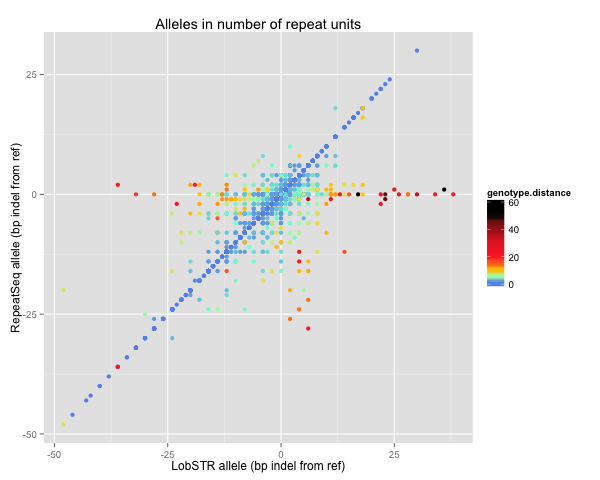

In [78]:
%%R -w 600
p = ggplot(LobSTR.RepeatSeq2, aes(colour=genotype.distance)) +
    geom_point(aes(x = LobSTR.indel1, y = RepeatSeq.indel1)) +
    geom_point(aes(x = LobSTR.indel2, y = RepeatSeq.indel2)) +
    scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
                                     'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
                                     'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
                                     'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units", 
         x='LobSTR allele (bp indel from ref)', y='RepeatSeq allele (bp indel from ref)')
print(p)

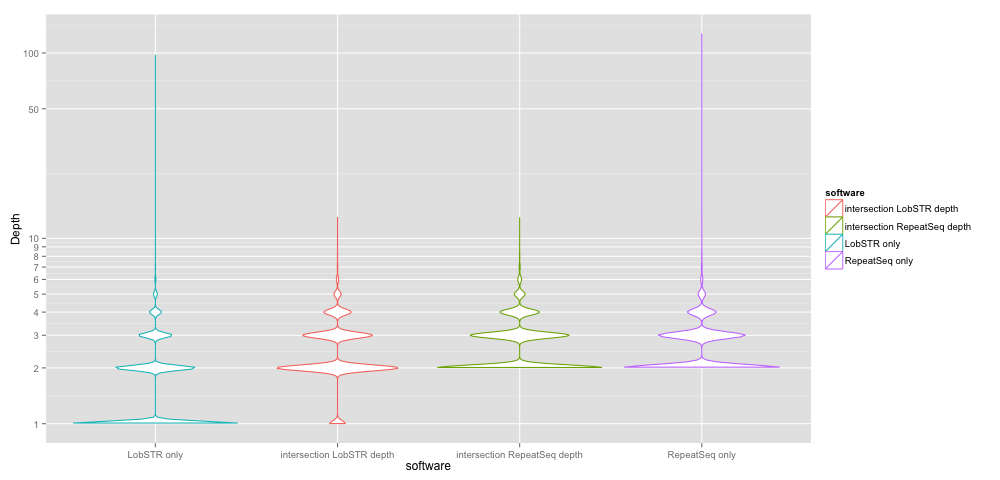

In [79]:
%%R -w 1000
temp.data.all = all.data2[c('LobSTR.depth', 'RepeatSeq.depth', 'software')]
temp.data = temp.data.all[temp.data.all$software == 'LobSTR_RepeatSeq',]
temp.data$software = 'RepeatSeq_LobSTR'
temp.data = rbind(temp.data.all, temp.data)

temp.data[temp.data$software == 'LobSTR_RepeatSeq',]$RepeatSeq.depth = NA
temp.data[temp.data$software == 'RepeatSeq_LobSTR',]$LobSTR.depth = NA

temp.data$software = revalue(temp.data$software, 
                             c("LobSTR"="LobSTR only", "LobSTR_RepeatSeq"="intersection LobSTR depth",
            "RepeatSeq_LobSTR"="intersection RepeatSeq depth", "RepeatSeq"="RepeatSeq only"))

# Violin plots of depth
p = ggplot(temp.data) +
    geom_violin(aes(x = software, y=LobSTR.depth, color=software)) +
    geom_violin(aes(x = software, y=RepeatSeq.depth, color=software)) + 
    scale_y_log10(breaks= c(seq(1, 10, 1), 50, 100) ) +
    ylab('Depth') +
    scale_x_discrete(limits=c("LobSTR only", "intersection LobSTR depth",
            "intersection RepeatSeq depth", "RepeatSeq only"))
print(p)

Using genotype.distance.group, LobSTR.genotypecategory, RepeatSeq.genotypecategory as id variables


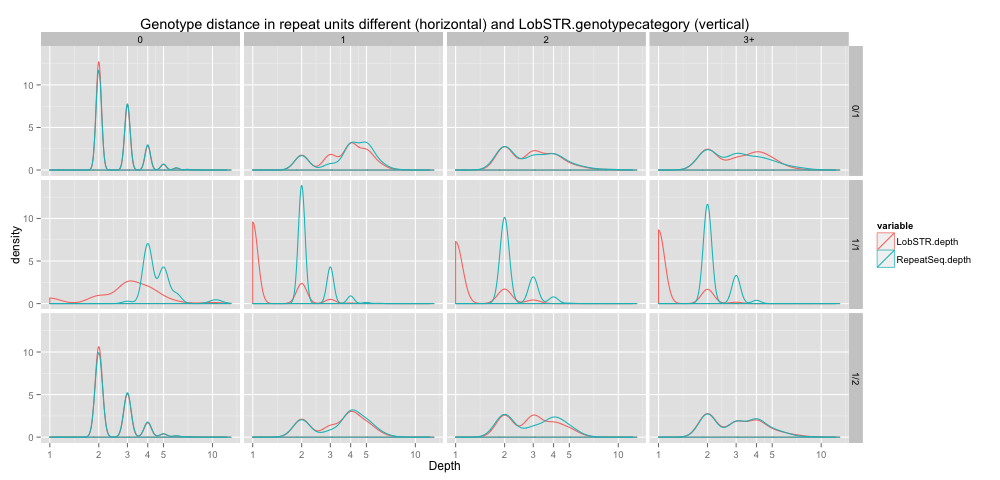

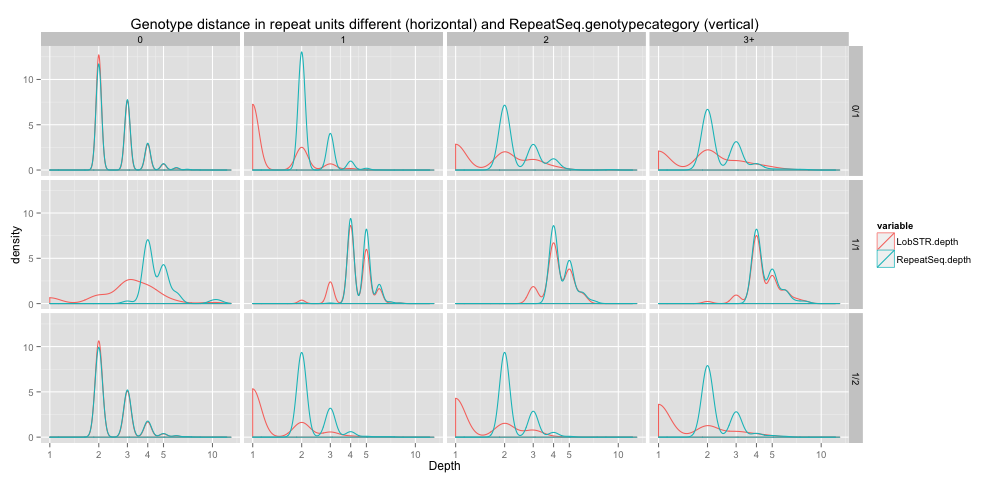

In [80]:
%%R -w 1000

temp.data = LobSTR.RepeatSeq2[c('LobSTR.depth', 'RepeatSeq.depth', 'genotype.distance.group', 'LobSTR.genotypecategory', 'RepeatSeq.genotypecategory')]
temp.data = melt(temp.data)

p = ggplot(temp.data) +
        geom_density(aes(x = value,
                         colour = variable)) +
    facet_grid(LobSTR.genotypecategory ~ genotype.distance.group) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 40, 10), 100)) + 
    labs(title="Genotype distance in repeat units different (horizontal) and LobSTR.genotypecategory (vertical)", x="Depth") 
print(p)

p = ggplot(temp.data) +
        geom_density(aes(x = value,
                         colour = variable)) +
    facet_grid(RepeatSeq.genotypecategory ~ genotype.distance.group) +
    scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 40, 10), 100)) + 
    labs(title="Genotype distance in repeat units different (horizontal) and RepeatSeq.genotypecategory (vertical)", x="Depth") 
print(p)

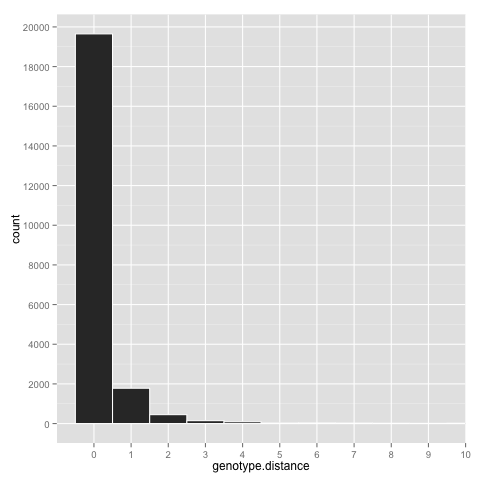

In [81]:
%%R
p = ggplot(LobSTR.RepeatSeq2) +
        geom_histogram(aes(x = genotype.distance), binwidth = 1, origin = -0.5, colour = "white") +
        coord_cartesian(xlim=c(-1,10)) +
        scale_x_discrete(breaks= seq(0, 10, 1)) +
        scale_y_continuous(breaks= seq(0, 20000, 2000))
        #scale_x_log10(breaks= c(seq(1, 5, 1), seq(10, 50, 10), 100))
print(p)

Using comparison as id variables
Using comparison as id variables


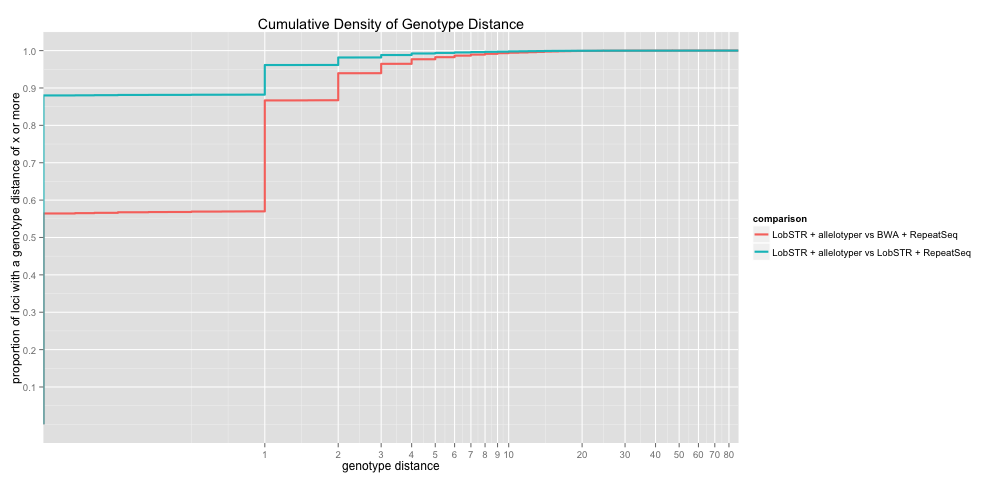

In [82]:
%%R -w 1000

tempdata1 = melt(data.frame(genotype.distance = LobSTR.RepeatSeq$genotype.distance, comparison='LobSTR + allelotyper vs BWA + RepeatSeq'))
tempdata2 = melt(data.frame(genotype.distance = LobSTR.RepeatSeq2$genotype.distance, comparison='LobSTR + allelotyper vs LobSTR + RepeatSeq'))
tempdata = rbind(tempdata1, tempdata2)

p = ggplot(tempdata,aes(x=value,colour=comparison)) + 
        geom_step(aes(y=..y..),stat="ecdf", size=1) +
        scale_x_log10(breaks= c(seq(1, 9, 1), seq(10, 100, 10))) + 
        scale_y_continuous(breaks= seq(.1, 1, .1) ) + 
        labs(title="Cumulative Density of Genotype Distance", 
             y="proportion of loci with a genotype distance of x or more",
             x="genotype distance") 
print(p)

Using pipeline as id variables
Using pipeline as id variables
Using pipeline as id variables
         pipeline        variable value
1 BWA + RepeatSeq RepeatSeq.depth     2
2 BWA + RepeatSeq RepeatSeq.depth    NA
3 BWA + RepeatSeq RepeatSeq.depth    NA
4 BWA + RepeatSeq RepeatSeq.depth    NA
5 BWA + RepeatSeq RepeatSeq.depth    NA
6 BWA + RepeatSeq RepeatSeq.depth    NA


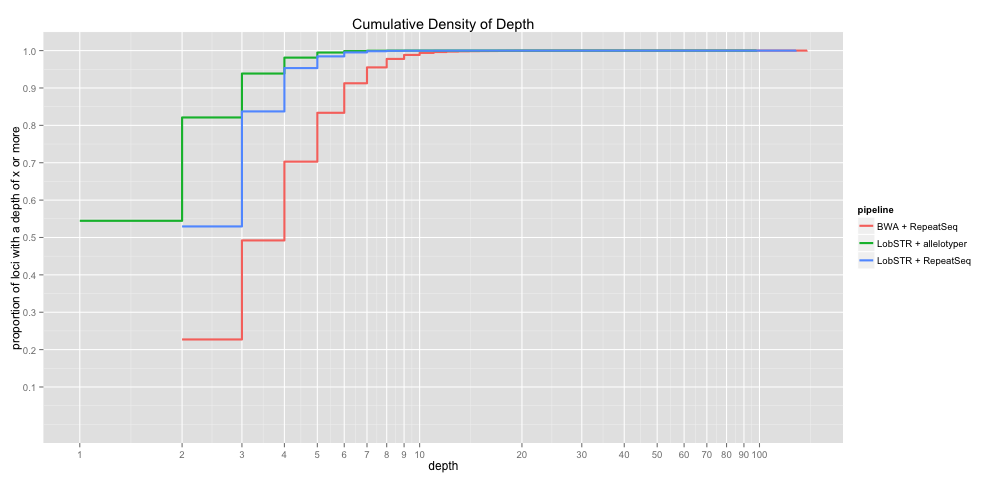

In [83]:
%%R -w 1000

tempdata1 = melt(data.frame(RepeatSeq.depth = all.data$RepeatSeq.depth, pipeline='BWA + RepeatSeq'))
tempdata2 = melt(data.frame(LobSTR.depth = all.data$LobSTR.depth, pipeline='LobSTR + allelotyper'))

tempdata3 = melt(data.frame(RepeatSeq.depth = all.data2$RepeatSeq.depth, pipeline='LobSTR + RepeatSeq'))
#tempdata4 = melt(data.frame(LobSTR.depth = all.data2$LobSTR.depth, pipeline='LobSTR + allelotyper 2'))

tempdata = rbind(tempdata1, tempdata2, tempdata3)

print(head(tempdata))

p = ggplot(tempdata,aes(x=value,colour=pipeline)) + 
        geom_step(aes(y=..y..),stat="ecdf", size=1) +
        scale_x_log10(breaks= c(seq(1, 9, 1), seq(10, 100, 10))) + 
        scale_y_continuous(breaks= seq(.1, 1, .1) ) + 
        labs(title="Cumulative Density of Depth", 
             y="proportion of loci with a depth of x or more",
             x="depth") 
print(p)

In [84]:
%%R -w 1000

tempdata1 = melt(data.frame(depth = all.data$RepeatSeq.depth, 
                            genotypecategory = all.data$RepeatSeq.genotypecategory,
                            pipeline = 'BWA + RepeatSeq'), 
                na.rm = T)
tempdata2 = melt(data.frame(depth = all.data$LobSTR.depth, 
                            genotypecategory = all.data$LobSTR.genotypecategory,
                            pipeline = 'LobSTR + allelotyper'), 
                na.rm = T)

tempdata3 = melt(data.frame(depth = all.data2$RepeatSeq.depth, 
                            genotypecategory = all.data2$RepeatSeq.genotypecategory,
                            pipeline = 'LobSTR + RepeatSeq'), 
                na.rm = T)
#tempdata4 = melt(data.frame(LobSTR.depth = all.data2$LobSTR.depth, pipeline='LobSTR + allelotyper 2'))

tempdata = rbind(tempdata1, tempdata2, tempdata3)




Using genotypecategory, pipeline as id variables
Using genotypecategory, pipeline as id variables
Using genotypecategory, pipeline as id variables


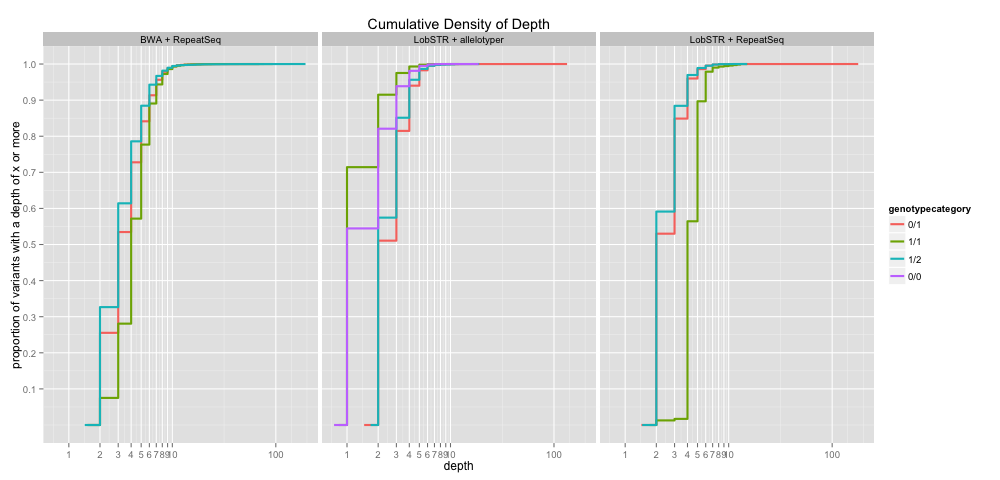

In [85]:
%%R -w 1000
p = ggplot(tempdata,aes(x=value,colour=genotypecategory)) + 
        geom_step(aes(y=..y..),stat="ecdf", size=1) +
        facet_wrap(~ pipeline) +
        scale_x_log10(breaks= c(seq(1, 10, 1), 100)) + 
        scale_y_continuous(breaks= seq(.1, 1, .1) ) + 
        labs(title="Cumulative Density of Depth", 
             y="proportion of variants with a depth of x or more",
             x="depth") 
print(p)


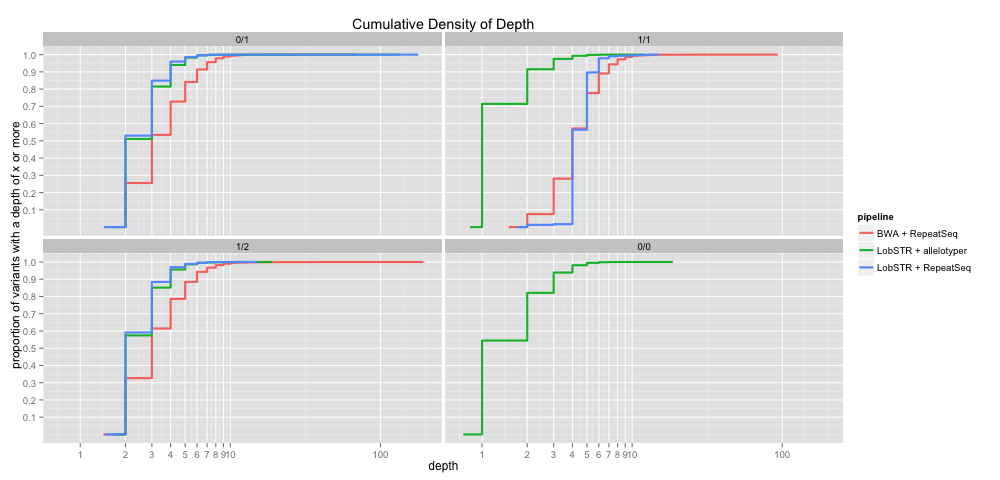

In [86]:
%%R -w 1000
p = ggplot(tempdata,aes(x=value,colour=pipeline)) + 
        geom_step(aes(y=..y..),stat="ecdf", size=1) +
        facet_wrap(~ genotypecategory) +
        scale_x_log10(breaks= c(seq(1, 10, 1), 100)) + 
        scale_y_continuous(breaks= seq(.1, 1, .1) ) + 
        labs(title="Cumulative Density of Depth", 
             y="proportion of variants with a depth of x or more",
             x="depth") 
print(p)

In [87]:
%%R -w 1000

tempdata1 = melt(cbind(all.data[c('RepeatSeq.depth', 'RepeatSeq.genotypecategory')], 
                            pipeline='BWA + RepeatSeq'))


Using RepeatSeq.genotypecategory, pipeline as id variables


## RepeatSeq vs. RepeatSeq - run on BWA vs. LobSTR bams

In [88]:
%%R 
#temp.data = cbind(LobSTR.RepeatSeq[c('RepeatSeq.indel1', 'RepeatsSeq.indel2')], 
#                  LobSTR.RepeatSeq2[c('RepeatSeq.indel1', 'RepeatsSeq.indel2')])

all.data3 = merge(x = all.data, y = all.data2, by = c('chr', 'pos'), all = TRUE, suffixes=c('.BWAbam', '.LobSTRbam'))

In [89]:
%%R
names(all.data3)

 [1] "chr"                                 
 [2] "pos"                                 
 [3] "software.BWAbam"                     
 [4] "LobSTR.REF.BWAbam"                   
 [5] "RepeatSeq.REF.BWAbam"                
 [6] "LobSTR.ALT.BWAbam"                   
 [7] "RepeatSeq.ALT.BWAbam"                
 [8] "LobSTR.QUAL.BWAbam"                  
 [9] "RepeatSeq.QUAL.BWAbam"               
[10] "LobSTR.refallelelen.BWAbam"          
[11] "RepeatSeq.refallelelen.BWAbam"       
[12] "LobSTR.repeatunit.BWAbam"            
[13] "RepeatSeq.repeatunit.BWAbam"         
[14] "LobSTR.normrepeatunit.BWAbam"        
[15] "RepeatSeq.normrepeatunit.BWAbam"     
[16] "LobSTR.repeatunitlen.BWAbam"         
[17] "RepeatSeq.repeatunitlen.BWAbam"      
[18] "LobSTR.genotype.BWAbam"              
[19] "RepeatSeq.genotype.BWAbam"           
[20] "LobSTR.depth.BWAbam"                 
[21] "RepeatSeq.depth.BWAbam"              
[22] "LobSTR.PL.BWAbam"                    
[23] "LobSTR.Q.BWAbam"          

In [90]:
%%R
LobSTR.RepeatSeq3 = all.data3[complete.cases(all.data3[c('RepeatSeq.genotype.BWAbam', 'RepeatSeq.genotype.LobSTRbam')]),] # Filter to loci shared by both
#LobSTR.RepeatSeq3 = LobSTR.RepeatSeq3[!LobSTR.RepeatSeq3$LobSTR.genotype == '0/0',] # Remove loci where LobSTR called 0/0 genotype

# Categorise Genotype Distance
#genotype.distance.group = cut(LobSTR.RepeatSeq3$genotype.distance, c(-Inf, seq(0, 2, 1), Inf), labels=c(0:2,'3+') )
#LobSTR.RepeatSeq3 = cbind(LobSTR.RepeatSeq3, genotype.distance.group)

#print(table(genotype.distance.group))
#barplot(table(genotype.distance.group))

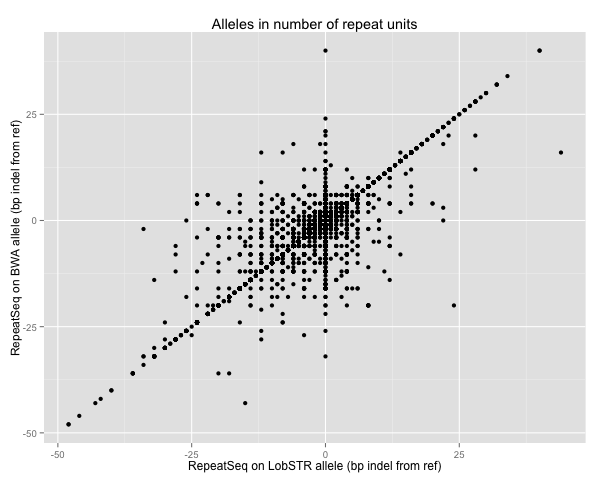

In [91]:
%%R -w 600
p = ggplot(LobSTR.RepeatSeq3) +#, aes(colour=genotype.distance)) +
    geom_point(aes(y = RepeatSeq.indel1.BWAbam, x = RepeatSeq.indel1.LobSTRbam)) +
    geom_point(aes(y = RepeatSeq.indel2.BWAbam, x = RepeatSeq.indel2.LobSTRbam)) +
    #scale_colour_gradientn(colours=c('cornflowerblue', 'aquamarine', 'gold', 'orange', 
    #                                 'firebrick1', 'firebrick1', 'firebrick2', 'firebrick2', 
    #                                 'firebrick3', 'firebrick3', 'firebrick4', 'firebrick4',
    #                                 'black', 'black', 'black', 'black')) +
    labs(title="Alleles in number of repeat units", 
         y='RepeatSeq on BWA allele (bp indel from ref)', x='RepeatSeq on LobSTR allele (bp indel from ref)')
print(p)

We see a different genotype when RepeatSeq is run on different bams. 
But the trend seems to have reversed! When using LobSTR bam it RepeatSeq calls a reference, while on BWA it calls an alternate! Is this just a matter of not comparing like with like for the alleles? Should I write a function to order them so it chooses the most similar pair to plot together, then the other pair as outliers?

In [92]:
%%R
#head(all.data, n=300)

NULL
